In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline

#### data preprocessing

##### AB Test Hit

In [4]:
ab = pd.read_csv(r'C:\Users\sunai\Downloads\data\Career Factory\AB Test Hit.csv', parse_dates=['hit_at'])

ab

,hit_at,anonymous_id,group,device_type,browser,os
0,2020-11-30 04:21:38.616 UTC,3e05a2dc-3922-4caf-b837-08fcb337c82e,default,desktop,IE,Windows
1,2020-12-01 20:24:04.363 UTC,7f00b6ca-7938-4866-a323-c520838f5ef9,default,desktop,IE,Windows
2,2020-11-28 20:16:52.901 UTC,91e9900e-2cc6-4362-92b4-9e6712a6918e,address_first,desktop,IE,Windows
3,2020-11-29 13:29:40.557 UTC,616dd5e8-dee2-47aa-9d80-0dfadcf1922f,default,desktop,IE,Windows
4,2020-11-27 14:56:29.471 UTC,64734da4-d9f3-4d53-b401-4d0819a6e5fb,default,desktop,IE,Windows
...,...,...,...,...,...,...
502779,2020-12-10 21:21:23.679 UTC,fb2764ef-5492-4dd0-b35f-f3a600b54168,default,tablet,Samsung Browser,Android
502780,2020-12-10 22:41:08.845 UTC,3b3edc2b-8627-467a-8188-99f781551f2a,default,mobile,Samsung Browser,Android
502781,2020-12-02 01:51:27.209 UTC,d58bc44a-b7cc-4156-b04b-bb8c8131ec77,default,desktop,Avast Secure Browser,Windows
502782,2020-12-05 09:43:06.159 UTC,5b996a40-a41c-4d09-b7cb-e82c33f11cff,default,desktop,Avast Secure Browser,Windows


In [5]:

ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502784 entries, 0 to 502783
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   hit_at        502784 non-null  object
 1   anonymous_id  502784 non-null  object
 2   group         502784 non-null  object
 3   device_type   502784 non-null  object
 4   browser       502784 non-null  object
 5   os            502783 non-null  object
dtypes: object(6)
memory usage: 23.0+ MB


In [6]:
# let's find the users who ended up in both the test and control groups
bad_ids = ab.groupby('anonymous_id', as_index=False) \
    .agg({'group': 'nunique'}) \
    .sort_values('group', ascending=False) \
    .query('group == 2').anonymous_id.to_list()

bad_ids

['9c896180-4a29-49fa-b2f2-5406608f699b',
 'a15f4465-40ed-43fd-9955-ea329e7af1d2',
 'c8b733d8-e0d6-4681-ab20-5a9131f93440',
 'dee73519-5e29-4073-a488-5140cafeb9b9',
 '837b463c-1731-4a0c-99a5-9abcc9d168c2',
 '0dc440a8-7e54-4fdf-883f-54d8dd9ec87a',
 '916090a7-3abc-4fc0-befe-4bb5fb4acce2',
 '8da9dfd0-7b70-4e98-a689-e89655e66684',
 '7dba40aa-4d15-41a3-bd85-ebfcddf09432',
 '2126f677-4f23-42a8-978a-08d51d9f770c',
 'b6b299e7-68f4-4acf-9084-d5113885b964',
 'a29ad181-c95e-442d-91e7-2c420f3b6fef',
 'fe07d909-ca54-42fd-a140-cf36884acf15',
 '2bedc3ea-34f0-4cb1-99d2-b63034140c6e',
 '056d91e7-3bc5-4e12-98d2-fc4e2403ff34',
 '7e2c2b79-9537-415e-9a9e-aa388f0877f1',
 '6eae3eb4-6dad-4d80-8ffd-149815624ffc',
 '76d6db8b-b413-4dc6-8110-221ab86fdd94',
 '39e51735-b37c-42ef-9e0d-84265767a6db',
 'de2c38be-6de4-4472-a506-1a634e3cc131',
 '81164caa-47b6-42a8-9752-c2c415915d5e',
 '370d8efa-9192-4202-a1b1-27c09cf5733e',
 'e608eaa7-f78d-4452-929d-2a48c0ac71ca',
 '43d1db46-c185-4699-b3fc-3ed6e2560b00',
 '3081890f-59fa-

In [7]:
len(bad_ids)

528

In [8]:
# checking whether a user belongs to both groups
ab[ab['anonymous_id'] == '9c896180-4a29-49fa-b2f2-5406608f699b']

,hit_at,anonymous_id,group,device_type,browser,os
469753,2020-12-06 13:14:26.983 UTC,9c896180-4a29-49fa-b2f2-5406608f699b,default,mobile,Chrome WebView,Android
479923,2020-12-06 13:14:26.998 UTC,9c896180-4a29-49fa-b2f2-5406608f699b,address_first,mobile,Chrome WebView,Android


In [9]:

ab = ab.query('anonymous_id not in @bad_ids')

In [10]:

def rem_duplicated(df, timestamp):
    ids = df[df[timestamp].duplicated() == True][timestamp].to_list()
    
    dupl_ts = []
    for ts in ids:
        if df.query('hit_at == @ts').anonymous_id.nunique() == 1:
            dupl_ts.append(ts)
    
    count = 0
    for ts in dupl_ts:
        if len(df.query('hit_at == @ts')) > 0:
            idx = df.query('hit_at == @ts').index
            for i in idx[1:]:
                df = df.drop(index=i)
                count += 1
            #dupl_ts.remove(ts)
    print(f'{count} duplicates were removed.')
    return df

ab = rem_duplicated(ab, 'hit_at')

0 duplicates were removed.


In [11]:
#checking whether user IDs appear in a group multiple times
ab[ab.anonymous_id.duplicated(keep=False) == True] \
    .groupby('anonymous_id') \
    .agg({'hit_at': 'count'}) \
    .sort_values('hit_at', ascending=False) \
    .rename(columns={'hit_at': 'hit_at_cnt'})

,hit_at_cnt
anonymous_id,
5bb785fd-e0e7-447a-b0e1-a06328b31cbe,18
1dea1cc9-72c0-4bee-bdb6-c59faacd72ba,15
06eaec3d-511a-4794-92ea-a19efaaf7f19,15
bcaa113d-c128-443f-9ede-2736847e1969,15
ba5239f5-1115-4caa-aef2-242a9c039b12,14
...,...
5c6a61ea-a507-40e2-8424-f6ef7df3bb2d,2
5c6c45b8-657c-417c-811a-d59b997a8990,2
5c71a65c-4bba-4ade-8914-f60d892f6800,2


In [12]:
#removing repeated occurrences of user IDs in one of the groups multiple times
ab = ab.sort_values('hit_at', ascending=True)\
    .drop_duplicates(subset=['anonymous_id'], keep='first')

##### Landing Viewed

In [14]:

landing_v = pd.read_csv(r'C:\Users\sunai\Downloads\data\Career Factory\Landing Viewed.csv', parse_dates=['timestamp'])

landing_v

,timestamp,anonymous_id
0,2020-12-05 10:01:51.305 UTC,00001104-4c72-4f48-bb8c-ace2ded63f8b
1,2020-12-08 11:07:39.962 UTC,00007575-88d6-4acc-9940-e9ccb8358dca
2,2020-12-03 13:12:37.952 UTC,00016e45-138b-401e-9eac-78b92d48c6c4
3,2020-12-02 16:03:37.548 UTC,0001814e-5cf7-4d23-bc95-4630d9152fc1
4,2020-12-01 08:24:51.787 UTC,00021d91-c65e-4049-9ae1-7d64702c8c12
...,...,...
341476,2020-12-05 14:54:01.768 UTC,fffedf6a-7be6-4313-a0d9-ff87463ba6e8
341477,2020-12-10 10:47:30.204 UTC,fffee334-8e5d-4923-b97e-c3ebb060d70b
341478,2020-12-04 19:15:55.857 UTC,fffee334-8e5d-4923-b97e-c3ebb060d70b
341479,2020-12-07 06:11:38.61 UTC,ffff53e1-df50-43dd-a1d3-c2e34271920b


In [15]:
landing_v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341481 entries, 0 to 341480
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   timestamp     341481 non-null  object
 1   anonymous_id  341481 non-null  object
dtypes: object(2)
memory usage: 5.2+ MB


In [16]:
#finding and removing duplicates simultaneously by time and user ID
def rem_duplicated(df, timestamp):
    ids = df[df[timestamp].duplicated() == True][timestamp].to_list()
    
    dupl_ts = []
    for ts in ids:
        if df.query('timestamp == @ts').anonymous_id.nunique() == 1:
            dupl_ts.append(ts)
    
    count = 0
    for ts in dupl_ts:
        if len(df.query('timestamp == @ts')) > 0:
            idx = df.query('timestamp == @ts').index
            for i in idx[1:]:
                df = df.drop(index=i)
                count += 1
            #dupl_ts.remove(ts)
    print(f'{count} duplicates were removed.')
    return df

landing_v = rem_duplicated(landing_v, 'timestamp')

116 duplicates were removed.


##### Main Page Viewed

In [18]:
main_page_v = pd.read_csv(r'C:\Users\sunai\Downloads\data\Career Factory\Main Page Viewed.csv', parse_dates=['timestamp'])

main_page_v

,timestamp,anonymous_id,retailer_id
0,2020-11-29 08:54:57.64 UTC,00000782-154a-4159-ab12-6c34b658e375,1
1,2020-11-29 08:22:54.554 UTC,00000782-154a-4159-ab12-6c34b658e375,1
2,2020-11-30 10:56:52.877 UTC,00000782-154a-4159-ab12-6c34b658e375,1
3,2020-11-29 08:22:24.663 UTC,00000782-154a-4159-ab12-6c34b658e375,1
4,2020-11-29 09:07:11.648 UTC,00000782-154a-4159-ab12-6c34b658e375,1
...,...,...,...
613504,2020-11-26 09:53:21.894 UTC,f62072ba-c666-4592-b2d5-627eafd445cd,253
613505,2020-12-01 15:47:22.935 UTC,f7195120-87dc-404d-a31c-afcfad71cc35,253
613506,2020-11-28 17:03:38.479 UTC,f84d997a-ce87-4e88-bf67-c2b1c50b71eb,253
613507,2020-11-29 13:38:47.575 UTC,fa1f6122-363e-4264-a92d-701a6fe44161,253


In [19]:
main_page_v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613509 entries, 0 to 613508
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   timestamp     613509 non-null  object
 1   anonymous_id  613509 non-null  object
 2   retailer_id   613509 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 14.0+ MB


In [20]:
main_page_v = rem_duplicated(main_page_v, 'timestamp')

201 duplicates were removed.


##### Address Change Initiated

In [22]:
address_c = pd.read_csv(r'C:\Users\sunai\Downloads\data\Career Factory\Address Change Initiated.csv', parse_dates=['timestamp'])

address_c

,timestamp,anonymous_id,source
0,2020-12-17 16:52:48.751 UTC,01005c8a-9fae-463e-89de-c96ba54b33d5,add_alcohol
1,2020-12-07 19:47:02.284 UTC,033b1952-ff45-48ff-b26f-6cdb78d549a2,add_alcohol
2,2020-12-16 06:54:25.958 UTC,03fc2ae5-318f-4292-b1c8-68e59923cd4f,add_alcohol
3,2020-12-10 18:27:01.658 UTC,045a73a6-49cf-430a-81ba-80d0062d8bea,add_alcohol
4,2020-12-09 08:47:39.586 UTC,06bf46cd-3aa9-4526-8ad8-889b7dabbdfd,add_alcohol
...,...,...,...
103429,2020-12-07 11:44:04.057 UTC,ff4aa09d-3dff-4081-af72-92674f13dd16,not_in_delivery_zone
103430,2020-12-10 21:14:34.09 UTC,ff963d29-a47b-48b6-ae2c-95c9a493e281,not_in_delivery_zone
103431,2020-12-10 21:13:55.326 UTC,ff963d29-a47b-48b6-ae2c-95c9a493e281,not_in_delivery_zone
103432,2020-12-17 18:48:55.322 UTC,ffa28c7d-2f59-4db9-a44f-9b09a1d5e457,not_in_delivery_zone


In [23]:

address_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103434 entries, 0 to 103433
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   timestamp     103434 non-null  object
 1   anonymous_id  103434 non-null  object
 2   source        103434 non-null  object
dtypes: object(3)
memory usage: 2.4+ MB


In [24]:

address_c = rem_duplicated(address_c, 'timestamp')

64 duplicates were removed.


##### Address not in delivery zone

In [26]:

address_not = pd.read_csv(r'C:\Users\sunai\Downloads\data\Career Factory\Address Not In Delivery Zone.csv', parse_dates=['timestamp'])

address_not

,timestamp,anonymous_id
0,2020-11-29 18:23:55.997 UTC,000dece9-6e24-4ea0-861e-3d71a055fc37
1,2020-12-05 04:15:49.615 UTC,000fe246-60f5-4b91-b26b-6dd10760d565
2,2020-12-05 12:13:05.248 UTC,0037b3e8-2a0e-4e86-a0a1-b3dd1d06501c
3,2020-12-05 12:04:23.065 UTC,0037b3e8-2a0e-4e86-a0a1-b3dd1d06501c
4,2020-12-05 12:06:42.038 UTC,0037b3e8-2a0e-4e86-a0a1-b3dd1d06501c
...,...,...
6162,2020-12-17 18:47:06.933 UTC,ffa28c7d-2f59-4db9-a44f-9b09a1d5e457
6163,2020-11-30 06:21:44.788 UTC,ffa8d479-2db4-4a55-a3c2-710bdbb581ec
6164,2020-11-30 06:21:48.006 UTC,ffa8d479-2db4-4a55-a3c2-710bdbb581ec
6165,2020-12-08 08:28:04.215 UTC,ffc3b5ac-d880-408c-8f3c-2d01a87a301c


In [27]:

address_not.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6167 entries, 0 to 6166
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   timestamp     6167 non-null   object
 1   anonymous_id  6167 non-null   object
dtypes: object(2)
memory usage: 96.5+ KB


In [28]:
address_not[address_not.timestamp.duplicated() == True]  

,timestamp,anonymous_id


##### Shop Selection Started

In [30]:

selection_started = pd.read_csv(r'C:\Users\sunai\Downloads\data\Career Factory\Shop Celection Started.csv', parse_dates=['timestamp'])

selection_started

,timestamp,anonymous_id,source
0,2020-12-01 09:49:12.615 UTC,1da378e1-ad44-48d6-8002-f39c59b3e21e,header
1,2020-12-01 03:17:26.084 UTC,a182785b-5da1-4445-92a6-c6ddafcc65df,header
2,2020-12-01 03:16:11.65 UTC,a182785b-5da1-4445-92a6-c6ddafcc65df,header
3,2020-12-01 03:15:10.845 UTC,a182785b-5da1-4445-92a6-c6ddafcc65df,header
4,2020-12-01 03:16:54.069 UTC,a182785b-5da1-4445-92a6-c6ddafcc65df,header
...,...,...,...
57402,2020-12-08 17:10:05.072 UTC,165d6f58-ba87-4c0a-99fe-e6c9693b39a5,address_modal
57403,2020-12-08 17:05:28.783 UTC,165d6f58-ba87-4c0a-99fe-e6c9693b39a5,address_modal
57404,2020-12-08 17:02:42.966 UTC,165d6f58-ba87-4c0a-99fe-e6c9693b39a5,address_modal
57405,2020-12-08 17:09:14.421 UTC,165d6f58-ba87-4c0a-99fe-e6c9693b39a5,address_modal


In [31]:
selection_started.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57407 entries, 0 to 57406
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   timestamp     57407 non-null  object
 1   anonymous_id  57407 non-null  object
 2   source        57407 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


In [32]:
selection_started = rem_duplicated(selection_started, 'timestamp')

2 duplicates were removed.


##### Shop Selected

In [34]:
shop_selected = pd.read_csv(r'C:\Users\sunai\Downloads\data\Career Factory\Shop Selected.csv', parse_dates=['timestamp'])

shop_selected

,timestamp,anonymous_id,source
0,2020-11-30 17:33:43.161 UTC,bc5ea2f8-fd4c-4f85-a0cb-f777bf87b82c,address_modal
1,2020-11-30 16:38:32.893 UTC,2462f92f-e1f5-49cb-8174-ea938d210fd3,header
2,2020-11-30 17:25:06.712 UTC,290c7999-8392-41f8-ab31-e208fe65bd82,header
3,2020-11-30 04:55:43.421 UTC,15975d1c-3b06-46a5-b2f3-a393cc0be2ee,header
4,2020-11-30 04:55:43.43 UTC,15975d1c-3b06-46a5-b2f3-a393cc0be2ee,header
...,...,...,...
211723,2020-12-06 20:37:45.22 UTC,95e07e4a-65c1-4387-9851-56a1427e61f5,header
211724,2020-12-06 16:16:54.724 UTC,30e33171-1624-499d-a77e-b9acf211c5ff,header
211725,2020-12-06 04:52:59.598 UTC,ab9689cc-adbf-47e1-bc40-61a7181a4016,header
211726,2020-12-06 04:52:59.416 UTC,ab9689cc-adbf-47e1-bc40-61a7181a4016,header


In [35]:
shop_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211728 entries, 0 to 211727
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   timestamp     211728 non-null  object
 1   anonymous_id  211728 non-null  object
 2   source        211728 non-null  object
dtypes: object(3)
memory usage: 4.8+ MB


In [36]:
shop_selected = rem_duplicated(shop_selected, 'timestamp')

769 duplicates were removed.


##### Add to cart clicked

In [38]:
add_clicked = pd.read_csv(r'C:\Users\sunai\Downloads\data\Career Factory\Add To Cart Clicked.csv', parse_dates=['timestamp'])

add_clicked

,timestamp,anonymous_id
0,2020-11-30 03:08:30.345 UTC,04880e58-9530-46c2-bf03-b9bc21e72e99
1,2020-11-30 11:13:52.439 UTC,74526202-97a7-49d7-b312-91d93583c530
2,2020-11-30 09:11:38.708 UTC,d246c872-7a1e-4a02-9440-0908ba605f79
3,2020-11-30 09:42:22.833 UTC,71102afd-bcf1-4585-aaba-819b68554c79
4,2020-11-30 03:38:11.446 UTC,df194e6d-d88a-4b18-bf44-209992dd9f7e
...,...,...
1223412,2020-11-29 11:24:48.766 UTC,2ab2ef69-c46d-4a4d-9300-74fe27614813
1223413,2020-11-29 11:22:45.471 UTC,2ab2ef69-c46d-4a4d-9300-74fe27614813
1223414,2020-11-29 11:16:39.212 UTC,2ab2ef69-c46d-4a4d-9300-74fe27614813
1223415,2020-11-29 11:19:40.169 UTC,2ab2ef69-c46d-4a4d-9300-74fe27614813


In [39]:
add_clicked.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1223417 entries, 0 to 1223416
Data columns (total 2 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   timestamp     1223417 non-null  object
 1   anonymous_id  1223417 non-null  object
dtypes: object(2)
memory usage: 18.7+ MB


In [40]:
add_clicked = rem_duplicated(add_clicked, 'timestamp')

157 duplicates were removed.


##### Product Added

In [42]:
product_added = pd.read_csv(r'C:\Users\sunai\Downloads\data\Career Factory\Product Added.csv', parse_dates=['timestamp'])

product_added

,timestamp,anonymous_id
0,2020-12-09 20:51:32.429 UTC,e2d50ef1-0667-4da4-88ef-ecbdd7c6a73a
1,2020-12-09 19:39:10.216 UTC,bb5ca977-97f4-4ec8-8a71-fe206108917b
2,2020-12-09 21:53:08.999 UTC,8e965f2b-7da0-4efb-84f5-f205956e8c30
3,2020-12-09 19:46:22.307 UTC,bb5ca977-97f4-4ec8-8a71-fe206108917b
4,2020-12-09 22:16:13.379 UTC,8e965f2b-7da0-4efb-84f5-f205956e8c30
...,...,...
1150055,2020-12-16 14:02:36.525 UTC,24e9b637-ec16-47c6-8f47-30c1703582dd
1150056,2020-12-16 13:47:42.788 UTC,d8f9457c-de6b-49d4-8a1d-e389eb56a29f
1150057,2020-12-16 13:01:23.606 UTC,d8f9457c-de6b-49d4-8a1d-e389eb56a29f
1150058,2020-12-16 13:50:52.321 UTC,d8f9457c-de6b-49d4-8a1d-e389eb56a29f


In [43]:
product_added.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150060 entries, 0 to 1150059
Data columns (total 2 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   timestamp     1150060 non-null  object
 1   anonymous_id  1150060 non-null  object
dtypes: object(2)
memory usage: 17.5+ MB


In [44]:
product_added = rem_duplicated(product_added, 'timestamp')

0 duplicates were removed.


##### Order Completed

In [46]:
completed = pd.read_csv(r'C:\Users\sunai\Downloads\data\Career Factory\Order Completed.csv', parse_dates=['timestamp'])

completed

,timestamp,anonymous_id,order_sum
0,2020-12-10 09:23:09.195 UTC,3343c486-8d88-44a6-87e5-5c1631e3db3d,3746.231921
1,2020-12-10 13:11:07.166 UTC,c4491ab9-e59e-444e-bd92-c462830e4b5b,1619.242047
2,2020-12-10 15:42:29.153 UTC,82f2bac5-8c73-4ed2-8022-27fa0dbd8fc2,2439.605901
3,2020-12-10 17:04:52.163 UTC,fffb6076-550e-445e-8227-68219671113a,1288.577888
4,2020-12-10 21:25:58.898 UTC,00e258f1-7908-467e-a66e-d42284ea3f2d,6875.955129
...,...,...,...
16645,2020-12-15 02:15:22.23 UTC,43e5cc04-046f-445a-8f43-ca8417b6e05a,71476.288670
16646,2020-12-15 11:02:21.91 UTC,e743a463-8d40-4c19-a97d-7520034114a9,4159.459050
16647,2020-12-15 01:06:20.549 UTC,89e104ef-6352-4b94-802e-82281044a8be,1492.155679
16648,2020-12-15 17:22:06.893 UTC,1b7b1c94-4581-4a40-9c23-93214b35411b,1651.523192


In [47]:
completed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16650 entries, 0 to 16649
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     16650 non-null  object 
 1   anonymous_id  16650 non-null  object 
 2   order_sum     16650 non-null  float64
dtypes: float64(1), object(2)
memory usage: 390.4+ KB


In [48]:
completed = rem_duplicated(completed, 'timestamp')

0 duplicates were removed.


#### Checking the uniformity of feature distributions

In [50]:
default = ab[ab['group'] == 'default']

default

,hit_at,anonymous_id,group,device_type,browser,os
467677,2020-11-26 00:00:10.318 UTC,8fe5810d-905c-462d-944b-66921878fa7d,default,mobile,Chrome WebView,Android
432135,2020-11-26 00:00:17.474 UTC,3ce00502-94c0-41c8-8165-20ea6d2ecd73,default,mobile,Mobile Safari,iOS
250308,2020-11-26 00:00:19.951 UTC,e9030181-192e-4636-9691-2ba4d1eeabb2,default,desktop,Chrome,Windows
489342,2020-11-26 00:00:24.159 UTC,20e24ee6-e40e-4f9a-9631-7db36332c734,default,mobile,Samsung Browser,Android
144584,2020-11-26 00:00:25.857 UTC,e9480708-34a6-4356-8e65-b39664875cb9,default,mobile,Chrome,Android
...,...,...,...,...,...,...
30732,2020-12-10 23:59:18.618 UTC,5e518207-82fb-48b9-9764-c167e84dc57c,default,desktop,Chrome,Linux
430450,2020-12-10 23:59:35.345 UTC,90b60ec1-4d0e-4fab-8cf0-6c5c128ea5ec,default,mobile,Mobile Safari,iOS
35510,2020-12-10 23:59:36.293 UTC,454c7515-0a58-4822-a431-d271e91da190,default,desktop,Chrome,Linux
199014,2020-12-10 23:59:48.461 UTC,ad4b596b-88d3-41e9-969a-7d988039405b,default,desktop,Chrome,Windows


In [51]:
test = ab[ab['group'] == 'address_first']

test

,hit_at,anonymous_id,group,device_type,browser,os
45810,2020-11-26 00:00:19.02 UTC,64f2ed52-52be-4171-917f-1834c0f736f2,address_first,desktop,Chrome,Linux
38251,2020-11-26 00:04:16.775 UTC,48e03311-f213-4b63-b2f9-ff2508b54a03,address_first,desktop,Chrome,Linux
59377,2020-11-26 00:04:58.764 UTC,85932680-44e5-4fd2-88dd-03167615f424,address_first,desktop,Chrome,Linux
43073,2020-11-26 00:05:18.216 UTC,a4ea1971-f41e-4943-921e-5142c7173ef1,address_first,desktop,Chrome,Linux
59378,2020-11-26 00:08:29.442 UTC,3543a788-6bc4-448e-9e97-ac5da585d7a4,address_first,desktop,Chrome,Linux
...,...,...,...,...,...,...
127029,2020-12-10 23:51:19.562 UTC,7f0a4f10-c49c-45a2-bb9e-92b4877b06eb,address_first,mobile,Chrome,Android
266369,2020-12-10 23:54:32.255 UTC,44eda551-929a-4891-b532-0aca11464a28,address_first,desktop,Chrome,Windows
490622,2020-12-10 23:56:33.386 UTC,993e5445-b06f-411a-80ef-818a6cd584d9,address_first,mobile,Samsung Browser,Android
485423,2020-12-10 23:57:47.998 UTC,d4ed11c9-e4e2-4781-bc1b-815bc8ae2608,address_first,mobile,Chrome WebView,Android


##### Checking the distribution of device types within groups

In [53]:
dev_type = default.groupby('device_type').count().reset_index()[['device_type', 'hit_at']]

dev_type

,device_type,hit_at
0,console,17
1,desktop,163734
2,mobile,264647
3,smarttv,15
4,tablet,5786


In [54]:
dev_type.loc[5] = ['others', 
                    dev_type.hit_at[0] + dev_type.hit_at[3] + dev_type.hit_at[4]]

dev_type = dev_type.sort_values('hit_at', ascending=False).reset_index(drop=True).head(3)

dev_type

,device_type,hit_at
0,mobile,264647
1,desktop,163734
2,others,5818


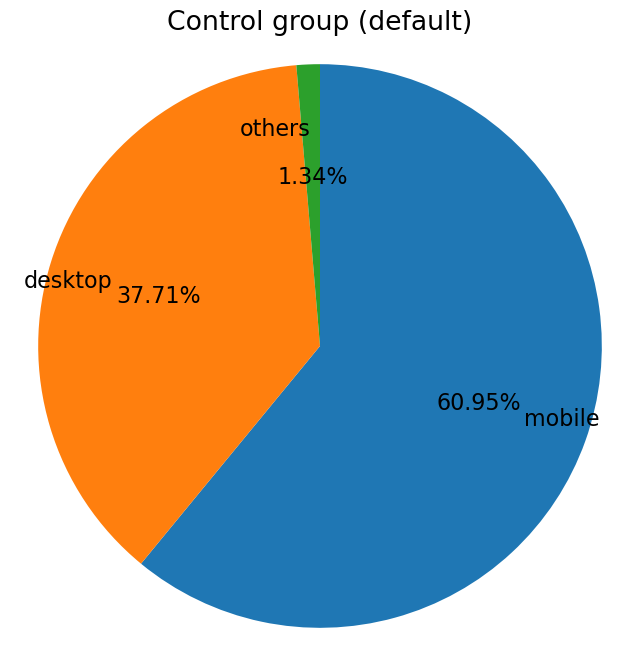

In [55]:
plt.figure(figsize=(8, 8))
plt.rcParams['font.size'] = 16.0
plt.pie(dev_type.hit_at, 
        labels=['mobile', 'desktop', 'others'], 
        autopct='%0.2f%%', labeldistance=0.77,
        counterclock=False, startangle=90);
plt.title('Control group (default)')
plt.axis('equal');
plt.savefig('control_device_pie.jpg')

In [56]:
dev_type = test.groupby('device_type').count().reset_index()[['device_type', 'hit_at']]

dev_type

,device_type,hit_at
0,console,1
1,desktop,20255
2,mobile,33287
3,smarttv,1
4,tablet,748


In [57]:
dev_type.loc[5] = ['others', 
                    dev_type.hit_at[0] + dev_type.hit_at[3] + dev_type.hit_at[4]]

dev_type = dev_type.sort_values('hit_at', ascending=False).reset_index(drop=True).head(3)

dev_type

,device_type,hit_at
0,mobile,33287
1,desktop,20255
2,others,750


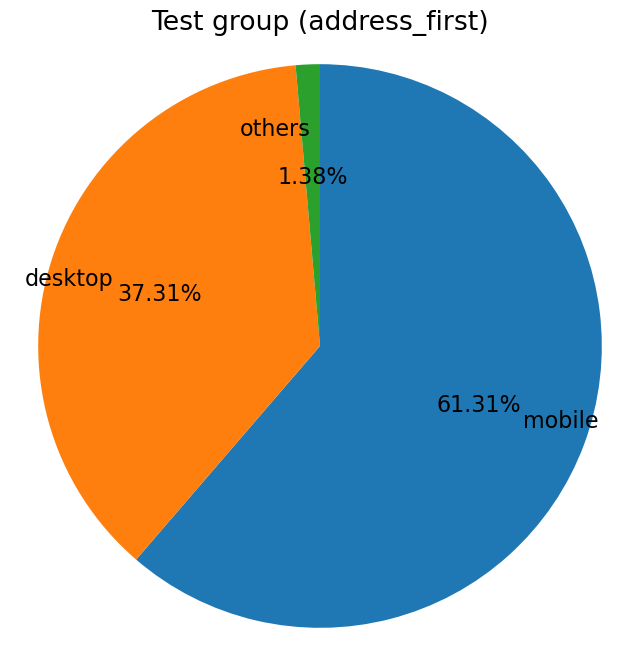

In [58]:
plt.figure(figsize=(8, 8))
plt.rcParams['font.size'] = 16.0
plt.pie(dev_type.hit_at, 
        labels=['mobile', 'desktop', 'others'], 
        autopct='%0.2f%%', labeldistance=0.77,
        counterclock=False, startangle=90);
plt.title('Test group (address_first)')
plt.axis('equal');

plt.savefig('test_device_pie.jpg')

##### Checking the distribution of OS types within groups

In [60]:
os_type = default.groupby('os', as_index=False).count()[['os', 'hit_at']] \
    .sort_values('hit_at', ascending=False).reset_index(drop=True)

os_type#.hit_at.sum()

,os,hit_at
0,Android,169736
1,Windows,118501
2,iOS,101917
3,Linux,31325
4,Mac OS,12151
5,Ubuntu,441
6,Chromium OS,43
7,Windows Phone,32
8,Fedora,19
9,PlayStation,13


In [61]:
os_type.loc[3] = ['Linux', 
                    os_type.hit_at[3] + os_type.hit_at[5] + os_type.hit_at[6] + os_type.hit_at[8] + os_type.hit_at[10] + os_type.hit_at[13]]

os_type.loc[14] = ['others', 
                    os_type.hit_at[4] + os_type.hit_at[7] + os_type.hit_at[9] + os_type.hit_at[11] + os_type.hit_at[12]]


os_type = os_type.sort_values('hit_at', ascending=False).reset_index(drop=True) \
    .iloc[[0, 1, 2, 3, 4]]

os_type

,os,hit_at
0,Android,169736
1,Windows,118501
2,iOS,101917
3,Linux,31841
4,others,12203


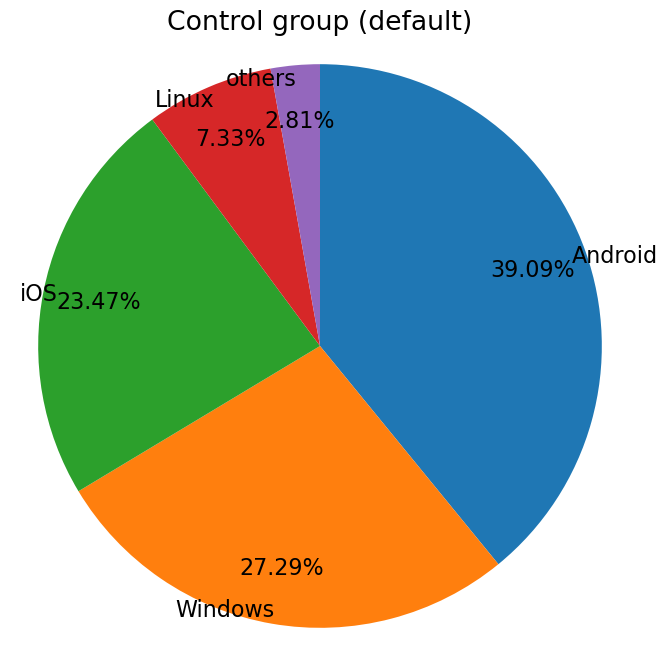

In [62]:
plt.figure(figsize=(8, 8))
plt.rcParams['font.size'] = 16.0
plt.pie(os_type.hit_at, 
        labels=['Android', 'Windows', 'iOS', 'Linux', 'others'], 
        autopct='%0.2f%%', 
        labeldistance=0.95, pctdistance=0.8, rotatelabels=False,
        counterclock=False, startangle=90);
plt.title('Control group (default)')
plt.axis('equal');
plt.savefig('control_os_pie.jpg')

In [63]:
os_type = test.groupby('os', as_index=False).count()[['os', 'hit_at']] \
    .sort_values('hit_at', ascending=False).reset_index(drop=True)

os_type#.hit_at.sum()

,os,hit_at
0,Android,21374
1,Windows,14652
2,iOS,12805
3,Linux,3877
4,Mac OS,1508
5,Ubuntu,60
6,Fedora,6
7,Chromium OS,5
8,Windows Phone,2
9,PlayStation,1


In [64]:
os_type.loc[3] = ['Linux', 
                    os_type.hit_at[3] + os_type.hit_at[5] + os_type.hit_at[6] + os_type.hit_at[7] + os_type.hit_at[10]]

os_type.loc[14] = ['others', 
                    os_type.hit_at[4] + os_type.hit_at[8] + os_type.hit_at[9] + os_type.hit_at[11]]


os_type = os_type.sort_values('hit_at', ascending=False).reset_index(drop=True) \
    .head()

os_type

,os,hit_at
0,Android,21374
1,Windows,14652
2,iOS,12805
3,Linux,3949
4,others,1512


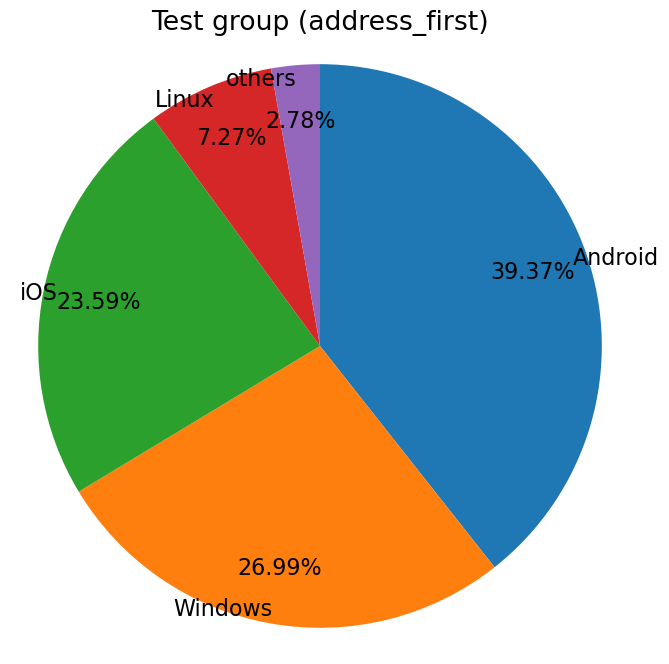

In [65]:
plt.figure(figsize=(8, 8))
plt.rcParams['font.size'] = 16.0
plt.pie(os_type.hit_at, 
        labels=['Android', 'Windows', 'iOS', 'Linux', 'others'], 
        autopct='%0.2f%%', 
        labeldistance=0.95, pctdistance=0.8, rotatelabels=False,
        counterclock=False, startangle=90);
plt.title('Test group (address_first)')
plt.axis('equal');
plt.savefig('test_os_pie.jpg')

##### Проверка по распределению типов браузеров внутри групп

In [67]:
browser_type = default.groupby('browser', as_index=False).count()[['browser', 'hit_at']] \
    .sort_values('hit_at', ascending=False).reset_index(drop=True)

browser_type#.hit_at.sum()

,browser,hit_at
0,Chrome,216615
1,Mobile Safari,71951
2,Yandex,46167
3,Chrome WebView,16599
4,WebKit,15821
5,Samsung Browser,13601
6,Firefox,12887
7,Opera,11098
8,MIUI Browser,10934
9,Safari,7528


In [68]:
browser_type.loc[37] = ['others', browser_type.iloc[5:].hit_at.sum()]


browser_type = browser_type.sort_values('hit_at', ascending=False).reset_index(drop=True).head()

In [69]:
browser_type = browser_type.iloc[[0, 1, 3, 4, 2]].reset_index(drop=True)

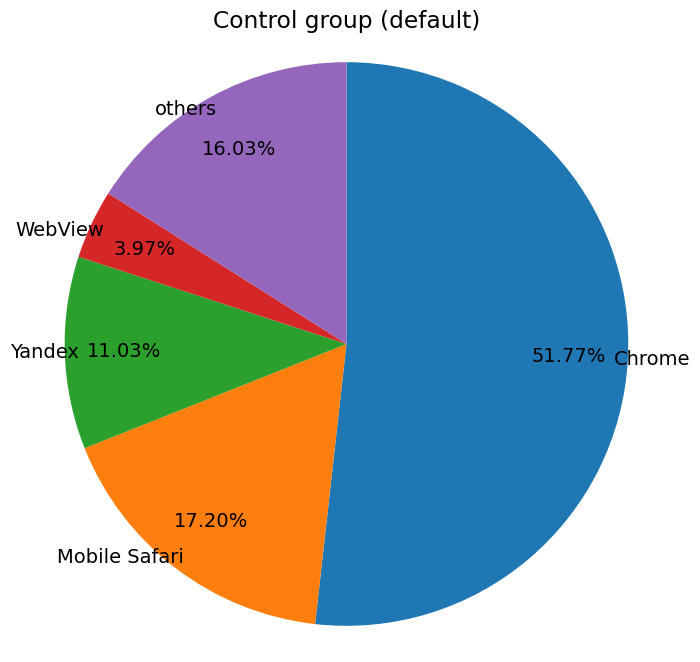

In [70]:
plt.figure(figsize=(8, 8))
plt.rcParams['font.size'] = 14.0
plt.pie(browser_type.hit_at, 
        labels=['Chrome', 'Mobile Safari', 'Yandex', 'WebView', 'others'], 
        autopct='%0.2f%%', 
        labeldistance=0.95, pctdistance=0.79, rotatelabels=False,
        counterclock=False, startangle=90);
plt.title('Control group (default)')
plt.axis('equal');
plt.savefig('control_browser_pie.jpg')

In [71]:
browser_type = test.groupby('browser', as_index=False).count()[['browser', 'hit_at']] \
    .sort_values('hit_at', ascending=False).reset_index(drop=True)

browser_type#.hit_at.sum()

,browser,hit_at
0,Chrome,27089
1,Mobile Safari,8935
2,Yandex,5806
3,Chrome WebView,2122
4,WebKit,2035
5,Samsung Browser,1661
6,Firefox,1600
7,Opera,1380
8,MIUI Browser,1362
9,Safari,939


In [72]:
browser_type.loc[26] = ['others', browser_type.iloc[5:].hit_at.sum()]


browser_type = browser_type.sort_values('hit_at', ascending=False).reset_index(drop=True).head()

In [73]:
browser_type = browser_type.iloc[[0, 1, 3, 4, 2]].reset_index(drop=True)

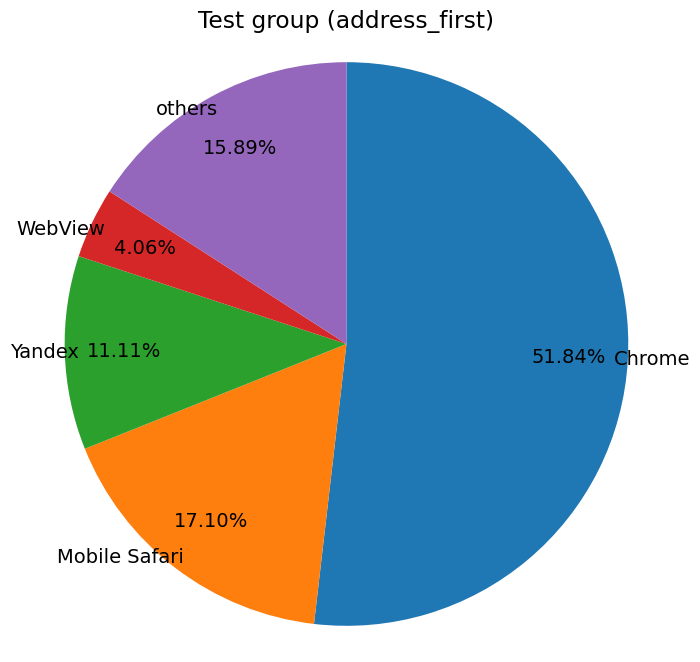

In [74]:
plt.figure(figsize=(8, 8))
plt.rcParams['font.size'] = 14.0
plt.pie(browser_type.hit_at, 
        labels=['Chrome', 'Mobile Safari', 'Yandex', 'WebView', 'others'], 
        autopct='%0.2f%%', 
        labeldistance=0.95, pctdistance=0.79, rotatelabels=False,
        counterclock=False, startangle=90);
plt.title('Test group (address_first)')
plt.axis('equal');
plt.savefig('test_browser_pie.jpg')

#### Bounce rate

##### default

In [77]:
default

,hit_at,anonymous_id,group,device_type,browser,os
467677,2020-11-26 00:00:10.318 UTC,8fe5810d-905c-462d-944b-66921878fa7d,default,mobile,Chrome WebView,Android
432135,2020-11-26 00:00:17.474 UTC,3ce00502-94c0-41c8-8165-20ea6d2ecd73,default,mobile,Mobile Safari,iOS
250308,2020-11-26 00:00:19.951 UTC,e9030181-192e-4636-9691-2ba4d1eeabb2,default,desktop,Chrome,Windows
489342,2020-11-26 00:00:24.159 UTC,20e24ee6-e40e-4f9a-9631-7db36332c734,default,mobile,Samsung Browser,Android
144584,2020-11-26 00:00:25.857 UTC,e9480708-34a6-4356-8e65-b39664875cb9,default,mobile,Chrome,Android
...,...,...,...,...,...,...
30732,2020-12-10 23:59:18.618 UTC,5e518207-82fb-48b9-9764-c167e84dc57c,default,desktop,Chrome,Linux
430450,2020-12-10 23:59:35.345 UTC,90b60ec1-4d0e-4fab-8cf0-6c5c128ea5ec,default,mobile,Mobile Safari,iOS
35510,2020-12-10 23:59:36.293 UTC,454c7515-0a58-4822-a431-d271e91da190,default,desktop,Chrome,Linux
199014,2020-12-10 23:59:48.461 UTC,ad4b596b-88d3-41e9-969a-7d988039405b,default,desktop,Chrome,Windows


In [78]:
# landing viewed
default_lw = default.merge(landing_v, on='anonymous_id', how='inner') \
    .rename(columns={'timestamp' : 'landing_viewed'})

default_lw

,hit_at,anonymous_id,group,device_type,browser,os,landing_viewed
0,2020-11-26 00:00:24.159 UTC,20e24ee6-e40e-4f9a-9631-7db36332c734,default,mobile,Samsung Browser,Android,2020-11-26 00:00:23.992 UTC
1,2020-11-26 00:00:25.857 UTC,e9480708-34a6-4356-8e65-b39664875cb9,default,mobile,Chrome,Android,2020-11-26 00:00:25.888 UTC
2,2020-11-26 00:00:32.364 UTC,d3a90bb4-b9d3-471a-b5d0-15837e369714,default,desktop,Chrome,Linux,2020-11-26 00:00:32.349 UTC
3,2020-11-26 00:00:33.04 UTC,4a2f6381-4a23-493c-bb97-626a65268397,default,desktop,Chrome,Linux,2020-11-26 00:00:33.026 UTC
4,2020-11-26 00:01:33.215 UTC,5ddc6caf-59f0-451c-b5ed-8c52548a67f9,default,desktop,Chrome,Mac OS,2020-11-26 00:01:33.352 UTC
...,...,...,...,...,...,...,...
305129,2020-12-10 23:58:55.288 UTC,251fb875-745b-4acd-8943-527cc0c518ef,default,mobile,Chrome,Android,2020-12-10 23:58:55.289 UTC
305130,2020-12-10 23:59:11.239 UTC,d68cd77b-f919-4841-a10f-f819b5526f79,default,mobile,Chrome,Android,2020-12-10 23:59:11.089 UTC
305131,2020-12-10 23:59:18.618 UTC,5e518207-82fb-48b9-9764-c167e84dc57c,default,desktop,Chrome,Linux,2020-12-10 23:59:18.603 UTC
305132,2020-12-10 23:59:36.293 UTC,454c7515-0a58-4822-a431-d271e91da190,default,desktop,Chrome,Linux,2020-12-10 23:59:36.278 UTC


In [79]:

default_lw = default_lw[['anonymous_id', 'hit_at', 'landing_viewed']].groupby(['anonymous_id', 'hit_at'], as_index=False) \
    .agg(lambda x: list(x))

In [80]:

default_lw['landing_view_cnt'] = default_lw.landing_viewed.apply(lambda x: len(x))

default_lw = default_lw.sort_values('landing_view_cnt', ascending=False).reset_index(drop=True)

In [81]:
default_lw

,anonymous_id,hit_at,landing_viewed,landing_view_cnt
0,06eaec3d-511a-4794-92ea-a19efaaf7f19,2020-11-26 07:28:22.464 UTC,"[2020-12-11 14:16:22.66 UTC, 2020-12-11 15:02:...",278
1,8851d1da-4b18-4028-baa6-47e8a135fe87,2020-12-02 08:59:21.322 UTC,"[2020-12-02 13:43:16.363 UTC, 2020-12-03 21:44...",170
2,3e3c5ef8-fb2d-4c9b-8de2-224c78ce4149,2020-11-28 17:08:13.424 UTC,"[2020-11-30 20:55:57.702 UTC, 2020-11-28 17:27...",142
3,bcaa113d-c128-443f-9ede-2736847e1969,2020-11-26 18:19:11.268 UTC,"[2020-11-30 09:54:04.223 UTC, 2020-12-05 08:19...",123
4,374fdafc-eaed-4265-bee1-ea62cd62d3bd,2020-11-27 15:59:33.515 UTC,"[2020-12-03 05:57:38.38 UTC, 2020-12-03 12:02:...",91
...,...,...,...,...
187180,63da59dc-49cd-4817-8aa1-ed0db5cdd2b8,2020-12-04 09:18:45.911 UTC,[2020-12-04 09:18:45.912 UTC],1
187181,63da8a14-c99b-4d28-9266-1cb08efa0a84,2020-11-30 20:37:31.024 UTC,[2020-11-30 20:37:31.025 UTC],1
187182,63daefcb-aa09-4268-92f3-a214f8562f6b,2020-12-06 18:00:01.215 UTC,[2020-12-06 18:00:01.078 UTC],1
187183,63daf46d-584b-495a-a94b-b1573ce2bbcb,2020-12-07 17:13:39.71 UTC,[2020-12-07 17:13:39.726 UTC],1


In [82]:
first_date = sorted(default_lw.iloc[0].landing_viewed)[0]
last_date = sorted(default_lw.iloc[0].landing_viewed)[-1]

print(first_date, last_date, sep='\n')

2020-11-26 07:28:22.465 UTC
2020-12-17 21:50:05.049 UTC


In [83]:
def iq_range(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    return q1, q3, q3 - q1

In [84]:
q1, q3, iqr = iq_range(default_lw, 'landing_view_cnt')

In [85]:
default_lw_filt = default_lw.query('(@q1 - 1.5*@iqr) <= landing_view_cnt <= (@q3 + 1.5*@iqr)')
default_lw_filt

,anonymous_id,hit_at,landing_viewed,landing_view_cnt
12527,1ef80740-195f-4167-9e69-09a10d7ec249,2020-12-03 10:21:39.868 UTC,"[2020-12-03 10:21:39.868 UTC, 2020-12-03 10:22...",3
12528,e918e9c6-a62a-4503-91d1-e3a3bba05c1a,2020-11-26 05:10:33.087 UTC,"[2020-11-26 05:10:33.087 UTC, 2020-11-26 05:16...",3
12529,359cccb9-0b9a-43f7-8c0e-07281c707150,2020-12-05 17:26:38.705 UTC,"[2020-12-05 17:26:38.704 UTC, 2020-12-05 18:30...",3
12530,e90911b1-b11c-4947-88a1-e97a2346d7f6,2020-12-05 18:46:40.781 UTC,"[2020-12-05 18:46:40.781 UTC, 2020-12-05 18:48...",3
12531,b84a350c-70bb-445c-9459-ba396490fdcc,2020-12-03 05:25:26.155 UTC,"[2020-12-03 05:25:26.029 UTC, 2020-12-03 05:25...",3
...,...,...,...,...
187180,63da59dc-49cd-4817-8aa1-ed0db5cdd2b8,2020-12-04 09:18:45.911 UTC,[2020-12-04 09:18:45.912 UTC],1
187181,63da8a14-c99b-4d28-9266-1cb08efa0a84,2020-11-30 20:37:31.024 UTC,[2020-11-30 20:37:31.025 UTC],1
187182,63daefcb-aa09-4268-92f3-a214f8562f6b,2020-12-06 18:00:01.215 UTC,[2020-12-06 18:00:01.078 UTC],1
187183,63daf46d-584b-495a-a94b-b1573ce2bbcb,2020-12-07 17:13:39.71 UTC,[2020-12-07 17:13:39.726 UTC],1


In [86]:
default_lw.landing_view_cnt.describe()

count    187185.000000
mean          1.630120
std           1.963639
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         278.000000
Name: landing_view_cnt, dtype: float64

In [87]:
default_lw_filt.landing_view_cnt.describe()

count    174658.000000
mean          1.296299
std           0.576965
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           3.000000
Name: landing_view_cnt, dtype: float64

In [88]:
main_page_v

,timestamp,anonymous_id,retailer_id
0,2020-11-29 08:54:57.64 UTC,00000782-154a-4159-ab12-6c34b658e375,1
1,2020-11-29 08:22:54.554 UTC,00000782-154a-4159-ab12-6c34b658e375,1
2,2020-11-30 10:56:52.877 UTC,00000782-154a-4159-ab12-6c34b658e375,1
3,2020-11-29 08:22:24.663 UTC,00000782-154a-4159-ab12-6c34b658e375,1
4,2020-11-29 09:07:11.648 UTC,00000782-154a-4159-ab12-6c34b658e375,1
...,...,...,...
613504,2020-11-26 09:53:21.894 UTC,f62072ba-c666-4592-b2d5-627eafd445cd,253
613505,2020-12-01 15:47:22.935 UTC,f7195120-87dc-404d-a31c-afcfad71cc35,253
613506,2020-11-28 17:03:38.479 UTC,f84d997a-ce87-4e88-bf67-c2b1c50b71eb,253
613507,2020-11-29 13:38:47.575 UTC,fa1f6122-363e-4264-a92d-701a6fe44161,253


In [89]:
mp_grouped = main_page_v.groupby(['anonymous_id'], as_index=False) \
    .agg(lambda x: list(x)) \
    .rename(columns={'timestamp': 'main_page_viewed'})

In [90]:
mp_grouped['main_page_view_cnt'] = mp_grouped.main_page_viewed.apply(lambda x: len(x))

mp_grouped = mp_grouped.sort_values('main_page_view_cnt', ascending=False).reset_index(drop=True)

mp_grouped

,anonymous_id,main_page_viewed,retailer_id,main_page_view_cnt
0,06eaec3d-511a-4794-92ea-a19efaaf7f19,"[2020-12-05 15:32:29.367 UTC, 2020-11-27 16:40...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",478
1,0d14ce81-19d5-451c-9c7f-1886ed3f71a6,"[2020-11-29 17:27:04.619 UTC, 2020-11-29 19:45...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",463
2,5d2114f3-01ec-4313-8629-3cb44b4a2f9d,"[2020-11-26 14:38:05.474 UTC, 2020-12-05 19:55...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",437
3,f8c6d1f8-230a-465b-b14b-db1c21ad49ae,"[2020-12-11 16:14:22.469 UTC, 2020-12-09 06:52...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",425
4,ddeb13ba-f506-4c5e-ae9c-a3b2786cb56f,"[2020-12-09 16:51:44.887 UTC, 2020-11-26 21:27...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",404
...,...,...,...,...
161200,74dc3e22-3221-444c-b7f1-d259cd6b7c76,[2020-11-30 10:11:08.855 UTC],[1],1
161201,74dbd1ba-c68e-4333-b264-80c1ae4fc7d8,[2020-12-09 15:55:48.21 UTC],[1],1
161202,74d9e6ef-cecf-44bd-9882-7f994b46df94,[2020-11-28 04:15:18.082 UTC],[1],1
161203,74d9affd-d12f-4385-b8af-828a1683547c,[2020-11-26 18:09:52.698 UTC],[1],1


In [91]:
mp_grouped.main_page_view_cnt.describe()

count    161205.000000
mean          3.804522
std           8.352212
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         478.000000
Name: main_page_view_cnt, dtype: float64

In [92]:
default_mpv = default_lw_filt.merge(mp_grouped, on='anonymous_id', how='left') \
    .sort_values('main_page_view_cnt', ascending=False) \
    .reset_index(drop=True)

default_mpv

,anonymous_id,hit_at,landing_viewed,landing_view_cnt,main_page_viewed,retailer_id,main_page_view_cnt
0,f8c6d1f8-230a-465b-b14b-db1c21ad49ae,2020-11-27 10:04:33.554 UTC,[2020-11-27 10:04:33.554 UTC],1,"[2020-12-11 16:14:22.469 UTC, 2020-12-09 06:52...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",425.0
1,ddeb13ba-f506-4c5e-ae9c-a3b2786cb56f,2020-12-10 13:12:38.736 UTC,"[2020-12-02 15:30:46.957 UTC, 2020-12-01 13:37...",3,"[2020-12-09 16:51:44.887 UTC, 2020-11-26 21:27...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",404.0
2,637e0f11-e9b7-42e4-ac2b-94b220bd6643,2020-11-28 06:58:26.728 UTC,"[2020-11-28 06:59:40.398 UTC, 2020-11-28 06:58...",2,"[2020-12-05 05:02:01.503 UTC, 2020-12-12 14:24...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",201.0
3,6d9393dd-d247-4f0d-9b89-cff18523cd7b,2020-12-07 20:08:16.304 UTC,"[2020-12-07 20:08:23.027 UTC, 2020-12-07 20:08...",2,"[2020-12-02 19:47:01.069 UTC, 2020-12-08 12:53...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",189.0
4,f1d57251-1373-458c-8b64-a8113414ff65,2020-12-02 15:56:15.765 UTC,"[2020-12-02 15:56:15.765 UTC, 2020-12-07 10:50...",3,"[2020-12-16 10:45:36.606 UTC, 2020-11-26 08:51...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",188.0
...,...,...,...,...,...,...,...
174653,63da4d2a-a97c-4821-b6e8-560098b94197,2020-12-06 01:16:45.943 UTC,[2020-12-06 01:16:45.959 UTC],1,NaN,NaN,NaN
174654,63da4d80-d372-44cc-8b65-643644e6779a,2020-11-30 12:49:50.388 UTC,[2020-11-30 12:49:50.389 UTC],1,NaN,NaN,NaN
174655,63da500b-bc32-48ab-b974-111857ae1642,2020-11-28 23:10:09.424 UTC,[2020-11-28 23:10:09.589 UTC],1,NaN,NaN,NaN
174656,63da8a14-c99b-4d28-9266-1cb08efa0a84,2020-11-30 20:37:31.024 UTC,[2020-11-30 20:37:31.025 UTC],1,NaN,NaN,NaN


In [93]:
default_mpv.main_page_view_cnt.describe()

count    77982.000000
mean         3.878793
std          7.087051
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        425.000000
Name: main_page_view_cnt, dtype: float64

In [94]:
default_mpv['main_page_view_cnt'].fillna(0, inplace=True)
default_mpv['main_page_view_cnt'] = default_mpv['main_page_view_cnt'].astype({'main_page_view_cnt': 'int'})

C:\Users\sunai\AppData\Local\Temp\ipykernel_77668\1229896243.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  default_mpv['main_page_view_cnt'].fillna(0, inplace=True)


In [95]:
q1, q3, iqr = iq_range(default_mpv, 'main_page_view_cnt')

In [96]:
default_mpv_filt = default_mpv.query('(@q1 - 1.5*@iqr) <= main_page_view_cnt <= (@q3 + 1.5*@iqr)')
default_mpv_filt

,anonymous_id,hit_at,landing_viewed,landing_view_cnt,main_page_viewed,retailer_id,main_page_view_cnt
12838,838e8c9a-4ac3-4231-a6b3-7c63bdb375e1,2020-11-26 18:00:46.068 UTC,[2020-11-26 17:36:28.248 UTC],1,"[2020-11-27 10:24:19.083 UTC, 2020-12-07 08:53...","[1, 1, 1, 1, 1]",5
12839,781c1674-e605-46b9-b421-bc7e80e4c3bd,2020-12-04 21:45:27.134 UTC,"[2020-12-04 21:45:27.132 UTC, 2020-12-04 21:48...",2,"[2020-12-04 21:48:19.553 UTC, 2020-12-04 21:46...","[1, 1, 1, 29, 57]",5
12840,4fa58fb4-3306-4dca-8829-0647bcac15e6,2020-12-04 13:54:45.722 UTC,[2020-12-04 13:54:45.721 UTC],1,"[2020-12-04 14:07:00.214 UTC, 2020-12-04 13:57...","[1, 1, 1, 29, 29]",5
12841,83337cd5-6c81-4edc-80cc-1b58602ea526,2020-12-02 04:38:11.893 UTC,[2020-12-02 04:38:12.059 UTC],1,"[2020-12-02 04:39:05.995 UTC, 2020-12-02 04:38...","[1, 1, 29, 57, 93]",5
12842,3eb3511b-b01c-4a2c-b1d5-376da68eab1b,2020-12-09 03:48:57.066 UTC,"[2020-12-09 03:59:33.757 UTC, 2020-12-09 03:48...",3,"[2020-12-09 03:59:43.437 UTC, 2020-12-09 03:56...","[29, 57, 325, 325, 325]",5
...,...,...,...,...,...,...,...
174653,63da4d2a-a97c-4821-b6e8-560098b94197,2020-12-06 01:16:45.943 UTC,[2020-12-06 01:16:45.959 UTC],1,NaN,NaN,0
174654,63da4d80-d372-44cc-8b65-643644e6779a,2020-11-30 12:49:50.388 UTC,[2020-11-30 12:49:50.389 UTC],1,NaN,NaN,0
174655,63da500b-bc32-48ab-b974-111857ae1642,2020-11-28 23:10:09.424 UTC,[2020-11-28 23:10:09.589 UTC],1,NaN,NaN,0
174656,63da8a14-c99b-4d28-9266-1cb08efa0a84,2020-11-30 20:37:31.024 UTC,[2020-11-30 20:37:31.025 UTC],1,NaN,NaN,0


In [97]:
default_mpv_filt.main_page_view_cnt.describe()

count    161820.000000
mean          0.807589
std           1.244334
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           5.000000
Name: main_page_view_cnt, dtype: float64

##### Bounce rate for default

In [99]:

default_mpv_filt['bounce'] = default_mpv_filt['main_page_view_cnt'].apply(lambda x: 0 if x > 0 else 1)

default_mpv_filt

C:\Users\sunai\AppData\Local\Temp\ipykernel_77668\93047074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  default_mpv_filt['bounce'] = default_mpv_filt['main_page_view_cnt'].apply(lambda x: 0 if x > 0 else 1)


,anonymous_id,hit_at,landing_viewed,landing_view_cnt,main_page_viewed,retailer_id,main_page_view_cnt,bounce
12838,838e8c9a-4ac3-4231-a6b3-7c63bdb375e1,2020-11-26 18:00:46.068 UTC,[2020-11-26 17:36:28.248 UTC],1,"[2020-11-27 10:24:19.083 UTC, 2020-12-07 08:53...","[1, 1, 1, 1, 1]",5,0
12839,781c1674-e605-46b9-b421-bc7e80e4c3bd,2020-12-04 21:45:27.134 UTC,"[2020-12-04 21:45:27.132 UTC, 2020-12-04 21:48...",2,"[2020-12-04 21:48:19.553 UTC, 2020-12-04 21:46...","[1, 1, 1, 29, 57]",5,0
12840,4fa58fb4-3306-4dca-8829-0647bcac15e6,2020-12-04 13:54:45.722 UTC,[2020-12-04 13:54:45.721 UTC],1,"[2020-12-04 14:07:00.214 UTC, 2020-12-04 13:57...","[1, 1, 1, 29, 29]",5,0
12841,83337cd5-6c81-4edc-80cc-1b58602ea526,2020-12-02 04:38:11.893 UTC,[2020-12-02 04:38:12.059 UTC],1,"[2020-12-02 04:39:05.995 UTC, 2020-12-02 04:38...","[1, 1, 29, 57, 93]",5,0
12842,3eb3511b-b01c-4a2c-b1d5-376da68eab1b,2020-12-09 03:48:57.066 UTC,"[2020-12-09 03:59:33.757 UTC, 2020-12-09 03:48...",3,"[2020-12-09 03:59:43.437 UTC, 2020-12-09 03:56...","[29, 57, 325, 325, 325]",5,0
...,...,...,...,...,...,...,...,...
174653,63da4d2a-a97c-4821-b6e8-560098b94197,2020-12-06 01:16:45.943 UTC,[2020-12-06 01:16:45.959 UTC],1,NaN,NaN,0,1
174654,63da4d80-d372-44cc-8b65-643644e6779a,2020-11-30 12:49:50.388 UTC,[2020-11-30 12:49:50.389 UTC],1,NaN,NaN,0,1
174655,63da500b-bc32-48ab-b974-111857ae1642,2020-11-28 23:10:09.424 UTC,[2020-11-28 23:10:09.589 UTC],1,NaN,NaN,0,1
174656,63da8a14-c99b-4d28-9266-1cb08efa0a84,2020-11-30 20:37:31.024 UTC,[2020-11-30 20:37:31.025 UTC],1,NaN,NaN,0,1


In [100]:
round(default_mpv_filt.bounce.value_counts(normalize=True)[1] * 100, 2)

59.74

##### test

In [102]:
# landing viewed
test_lw = test.merge(landing_v, on='anonymous_id', how='inner') \
    .rename(columns={'timestamp' : 'landing_viewed'})

test_lw

,hit_at,anonymous_id,group,device_type,browser,os,landing_viewed
0,2020-11-26 00:00:19.02 UTC,64f2ed52-52be-4171-917f-1834c0f736f2,address_first,desktop,Chrome,Linux,2020-11-26 00:00:19.019 UTC
1,2020-11-26 00:04:16.775 UTC,48e03311-f213-4b63-b2f9-ff2508b54a03,address_first,desktop,Chrome,Linux,2020-11-26 00:04:16.776 UTC
2,2020-11-26 00:04:58.764 UTC,85932680-44e5-4fd2-88dd-03167615f424,address_first,desktop,Chrome,Linux,2020-11-26 00:04:58.765 UTC
3,2020-11-26 00:05:18.216 UTC,a4ea1971-f41e-4943-921e-5142c7173ef1,address_first,desktop,Chrome,Linux,2020-11-26 00:05:18.216 UTC
4,2020-11-26 00:08:29.442 UTC,3543a788-6bc4-448e-9e97-ac5da585d7a4,address_first,desktop,Chrome,Linux,2020-11-26 00:08:29.457 UTC
...,...,...,...,...,...,...,...
35555,2020-12-10 23:47:10.128 UTC,fc9a8035-4ad1-40d2-95ec-48dd0a90683d,address_first,desktop,Chrome,Linux,2020-12-10 23:47:10.128 UTC
35556,2020-12-10 23:47:18.41 UTC,c76dbf12-1f78-485e-8384-c7c2241b07ea,address_first,desktop,Chrome,Linux,2020-12-10 23:47:18.409 UTC
35557,2020-12-10 23:48:22.844 UTC,6f351e94-2668-4927-86be-1c307e52329c,address_first,desktop,Chrome,Linux,2020-12-10 23:48:22.85 UTC
35558,2020-12-10 23:51:19.562 UTC,7f0a4f10-c49c-45a2-bb9e-92b4877b06eb,address_first,mobile,Chrome,Android,2020-12-10 23:51:19.562 UTC


In [103]:

test_lw = test_lw[['anonymous_id', 'hit_at', 'landing_viewed']].groupby(['anonymous_id', 'hit_at'], as_index=False) \
    .agg(lambda x: list(x))

In [104]:

test_lw['landing_view_cnt'] = test_lw.landing_viewed.apply(lambda x: len(x))

test_lw = test_lw.sort_values('landing_view_cnt', ascending=False).reset_index(drop=True)

In [105]:
test_lw

,anonymous_id,hit_at,landing_viewed,landing_view_cnt
0,6368eb82-d361-4aca-869e-080f167e3b5f,2020-12-01 00:57:15.357 UTC,"[2020-12-01 00:57:47.439 UTC, 2020-12-01 01:13...",532
1,8da49d4a-48a7-4e27-8a16-5d122c9602c4,2020-12-02 17:14:50.225 UTC,"[2020-12-08 15:26:04.107 UTC, 2020-12-08 16:05...",126
2,43565189-ddcb-4d0e-981c-91eb105ee2aa,2020-12-03 07:43:42.571 UTC,"[2020-12-10 17:37:24.233 UTC, 2020-12-11 19:27...",83
3,f20faf0a-75c6-41d4-a12e-472ce3b923b8,2020-11-27 18:11:49.984 UTC,"[2020-12-12 19:01:52.862 UTC, 2020-12-13 19:27...",47
4,cedad510-b65c-4077-82b2-88b020e62f79,2020-11-26 20:37:53.819 UTC,"[2020-11-27 06:46:01.309 UTC, 2020-11-27 07:36...",38
...,...,...,...,...
23545,6117f53f-ed37-443d-be6d-b5bd1d61088d,2020-11-27 18:24:07.506 UTC,[2020-11-27 18:24:07.655 UTC],1
23546,6115517c-bb51-4068-85fb-c64b75638dee,2020-12-03 13:06:01.228 UTC,[2020-12-03 13:06:01.258 UTC],1
23547,6114feb3-5192-47ab-a61b-4f45a33646f7,2020-12-03 08:05:17.151 UTC,[2020-12-03 08:07:15.844 UTC],1
23548,611386ec-1212-4e3c-8569-61d6ac055e8f,2020-11-26 13:46:18.473 UTC,[2020-11-26 13:46:18.473 UTC],1


In [106]:
first_date = sorted(test_lw.iloc[0].landing_viewed)[0]
last_date = sorted(test_lw.iloc[0].landing_viewed)[-1]

print(first_date, last_date, sep='\n')

2020-12-01 00:57:13.875 UTC
2020-12-01 01:27:25.05 UTC


In [107]:

def iq_range(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    return q1, q3, q3 - q1

In [108]:

q1, q3, iqr = iq_range(test_lw, 'landing_view_cnt')

In [109]:

test_lw_filt = test_lw.query('(@q1 - 1.5*@iqr) <= landing_view_cnt <= (@q3 + 1.5*@iqr)')
test_lw_filt

,anonymous_id,hit_at,landing_viewed,landing_view_cnt
5584,b1a937b9-6cdf-471a-bbc8-5f174cd6bc38,2020-12-04 19:09:27.293 UTC,[2020-12-04 19:09:27.233 UTC],1
5585,b19fb964-747b-4741-a07c-03db74987ba7,2020-11-26 15:55:36.346 UTC,[2020-11-26 15:55:36.376 UTC],1
5586,906fba24-63d8-47c7-b634-2d04ec0f3d02,2020-11-26 02:29:16.233 UTC,[2020-11-26 02:29:16.233 UTC],1
5587,b19f3e94-0af9-40b5-bd29-d24b6113588d,2020-12-02 08:48:33.873 UTC,[2020-12-02 08:48:33.873 UTC],1
5588,9645e242-b7bf-47c3-9015-01b51dcb0daa,2020-12-09 02:53:23.62 UTC,[2020-12-09 02:53:23.575 UTC],1
...,...,...,...,...
23545,6117f53f-ed37-443d-be6d-b5bd1d61088d,2020-11-27 18:24:07.506 UTC,[2020-11-27 18:24:07.655 UTC],1
23546,6115517c-bb51-4068-85fb-c64b75638dee,2020-12-03 13:06:01.228 UTC,[2020-12-03 13:06:01.258 UTC],1
23547,6114feb3-5192-47ab-a61b-4f45a33646f7,2020-12-03 08:05:17.151 UTC,[2020-12-03 08:07:15.844 UTC],1
23548,611386ec-1212-4e3c-8569-61d6ac055e8f,2020-11-26 13:46:18.473 UTC,[2020-11-26 13:46:18.473 UTC],1


In [110]:

test_lw.landing_view_cnt.describe()

count    23550.000000
mean         1.509979
std          3.872535
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        532.000000
Name: landing_view_cnt, dtype: float64

In [111]:

test_lw_filt.landing_view_cnt.describe()

count    17966.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: landing_view_cnt, dtype: float64

In [ ]:
address_c_landing = address_c[address_c['source'] == 'landing']

address_c_landing

,timestamp,anonymous_id,source
31643,2020-11-28 09:19:15.269 UTC,0007e6dd-f368-4108-bd3c-93fd3dc4f880,landing
31644,2020-11-28 11:03:05.779 UTC,000aad95-885c-4d32-80c1-c53434a17ac9,landing
31645,2020-12-09 06:52:47.76 UTC,0015e7d0-b4be-4fef-918c-668cc4bad1ea,landing
31646,2020-12-04 20:15:29.136 UTC,00292def-6714-49fe-940a-5cfda3cbf84b,landing
31647,2020-12-04 06:33:53.533 UTC,004aec46-3e7f-4003-bd37-a665d6acd719,landing
...,...,...,...
44721,2020-12-05 07:42:25.191 UTC,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,landing
44722,2020-11-28 15:12:50.754 UTC,ffede279-08d7-4d51-b5d5-d6e5e8983900,landing
44723,2020-12-02 18:37:58.82 UTC,ffef2c0e-814d-477c-a0cd-352163f52528,landing
44724,2020-11-26 15:22:46.495 UTC,fffa7926-b5a3-4533-a737-c6e4f351243b,landing


In [113]:
address_c_grouped = address_c_landing.groupby(['anonymous_id'], as_index=False) \
    .agg(lambda x: list(x)) \
    .rename(columns={'timestamp': 'main_page_viewed'})

In [114]:
address_c_grouped['main_page_view_cnt'] = address_c_grouped.main_page_viewed.apply(lambda x: len(x))

address_c_grouped = address_c_grouped.sort_values('main_page_view_cnt', ascending=False).reset_index(drop=True)

address_c_grouped

,anonymous_id,main_page_viewed,source,main_page_view_cnt
0,0d82c7f8-f2f0-4b22-a7ae-d430febadb15,"[2020-12-02 11:48:50.334 UTC, 2020-12-02 11:49...","[landing, landing, landing, landing, landing, ...",25
1,f5352ff3-0833-4b82-a8ea-afa154a9f440,"[2020-12-08 14:56:46.028 UTC, 2020-12-08 13:10...","[landing, landing, landing, landing, landing, ...",21
2,bd2d24ed-057d-46f8-a723-3d76617fc745,"[2020-12-12 07:56:30.852 UTC, 2020-12-12 07:55...","[landing, landing, landing, landing, landing, ...",21
3,30295241-3542-4924-9f7d-71de252e2f59,"[2020-12-09 12:38:06.688 UTC, 2020-12-09 12:38...","[landing, landing, landing, landing, landing, ...",19
4,1b2fda8f-0ea2-4656-a116-fd585cce42d6,"[2020-12-08 13:12:42.723 UTC, 2020-12-08 13:12...","[landing, landing, landing, landing, landing, ...",16
...,...,...,...,...
8758,61ef4b32-3a60-4017-bab2-16d733ba86ba,[2020-12-03 09:32:12.297 UTC],[landing],1
8759,61edcf66-629c-49fa-8474-ae537b395899,[2020-12-05 18:15:40.526 UTC],[landing],1
8760,61ea3df4-7225-4363-9f82-c42d0dffd359,[2020-11-26 13:27:40.852 UTC],[landing],1
8761,61e6c270-0b0d-43b0-a75d-afa013608d16,[2020-12-10 22:12:38.506 UTC],[landing],1


In [115]:
address_c_grouped.main_page_view_cnt.describe()

count    8763.000000
mean        1.491727
std         1.166867
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        25.000000
Name: main_page_view_cnt, dtype: float64

In [116]:
test_mpv = test_lw_filt.merge(address_c_grouped, on='anonymous_id', how='left') \
    .sort_values('main_page_view_cnt', ascending=False) \
    .reset_index(drop=True)

test_mpv

,anonymous_id,hit_at,landing_viewed,landing_view_cnt,main_page_viewed,source,main_page_view_cnt
0,30295241-3542-4924-9f7d-71de252e2f59,2020-12-09 12:36:43.524 UTC,[2020-12-09 12:36:43.525 UTC],1,"[2020-12-09 12:38:06.688 UTC, 2020-12-09 12:38...","[landing, landing, landing, landing, landing, ...",19.0
1,efdfdf43-0048-4a4c-9d72-5a99651e6cdd,2020-12-10 09:00:20.523 UTC,[2020-12-10 09:00:20.524 UTC],1,"[2020-12-10 09:01:35.023 UTC, 2020-12-10 09:01...","[landing, landing, landing, landing, landing, ...",16.0
2,1b2fda8f-0ea2-4656-a116-fd585cce42d6,2020-12-08 13:11:36.504 UTC,[2020-12-08 13:11:36.64 UTC],1,"[2020-12-08 13:12:42.723 UTC, 2020-12-08 13:12...","[landing, landing, landing, landing, landing, ...",16.0
3,7f848348-27d9-4056-9326-bde420e52fb7,2020-12-08 14:27:57.425 UTC,[2020-12-08 14:27:57.409 UTC],1,"[2020-12-08 15:18:12.522 UTC, 2020-12-08 14:30...","[landing, landing, landing, landing, landing, ...",10.0
4,28c8e99e-333e-4039-9684-73803f45a04c,2020-12-08 08:55:27.641 UTC,[2020-12-08 08:55:27.64 UTC],1,"[2020-12-08 08:56:28.714 UTC, 2020-12-08 08:55...","[landing, landing, landing, landing, landing, ...",9.0
...,...,...,...,...,...,...,...
17961,611e749e-9bbd-411c-9cdb-21d36d852495,2020-12-07 12:27:20.506 UTC,[2020-12-07 12:27:20.673 UTC],1,NaN,NaN,NaN
17962,6117f53f-ed37-443d-be6d-b5bd1d61088d,2020-11-27 18:24:07.506 UTC,[2020-11-27 18:24:07.655 UTC],1,NaN,NaN,NaN
17963,6115517c-bb51-4068-85fb-c64b75638dee,2020-12-03 13:06:01.228 UTC,[2020-12-03 13:06:01.258 UTC],1,NaN,NaN,NaN
17964,611386ec-1212-4e3c-8569-61d6ac055e8f,2020-11-26 13:46:18.473 UTC,[2020-11-26 13:46:18.473 UTC],1,NaN,NaN,NaN


In [117]:
test_mpv.main_page_view_cnt.describe()

count    5985.000000
mean        1.200501
std         0.707272
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        19.000000
Name: main_page_view_cnt, dtype: float64

In [118]:
test_mpv['main_page_view_cnt'].fillna(0, inplace=True)
test_mpv['main_page_view_cnt'] = test_mpv['main_page_view_cnt'].astype({'main_page_view_cnt': 'int'})

C:\Users\sunai\AppData\Local\Temp\ipykernel_77668\3867461147.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_mpv['main_page_view_cnt'].fillna(0, inplace=True)


In [119]:
q1, q3, iqr = iq_range(test_mpv, 'main_page_view_cnt')

In [120]:
test_mpv_filt = test_mpv.query('(@q1 - 1.5*@iqr) <= main_page_view_cnt <= (@q3 + 1.5*@iqr)')
test_mpv_filt

,anonymous_id,hit_at,landing_viewed,landing_view_cnt,main_page_viewed,source,main_page_view_cnt
192,ce3e9c63-04af-4628-80b8-bba26a72894f,2020-12-04 04:24:49.452 UTC,[2020-12-04 04:24:49.452 UTC],1,"[2020-12-04 04:25:31.602 UTC, 2020-12-04 04:25...","[landing, landing]",2
193,e54f1338-662b-4a72-aefe-f8b648169506,2020-12-10 15:51:03.3 UTC,[2020-12-10 15:51:03.293 UTC],1,"[2020-12-10 15:52:06.738 UTC, 2020-12-10 15:51...","[landing, landing]",2
194,4b681db3-d759-4828-8de5-fe0123d6b962,2020-12-05 07:09:43.002 UTC,[2020-12-05 07:09:43.033 UTC],1,"[2020-12-05 07:09:56.586 UTC, 2020-12-05 07:09...","[landing, landing]",2
195,0705203f-d138-4847-9380-d6a582f56c30,2020-12-02 12:35:00.31 UTC,[2020-12-02 12:35:00.31 UTC],1,"[2020-12-02 12:35:21.534 UTC, 2020-12-02 12:35...","[landing, landing]",2
196,e7f1c723-1e24-4602-9d70-9f83ce5ded5b,2020-12-02 19:27:31.065 UTC,[2020-12-02 19:36:19.968 UTC],1,"[2020-12-02 19:36:49.538 UTC, 2020-12-02 19:39...","[landing, landing]",2
...,...,...,...,...,...,...,...
17961,611e749e-9bbd-411c-9cdb-21d36d852495,2020-12-07 12:27:20.506 UTC,[2020-12-07 12:27:20.673 UTC],1,NaN,NaN,0
17962,6117f53f-ed37-443d-be6d-b5bd1d61088d,2020-11-27 18:24:07.506 UTC,[2020-11-27 18:24:07.655 UTC],1,NaN,NaN,0
17963,6115517c-bb51-4068-85fb-c64b75638dee,2020-12-03 13:06:01.228 UTC,[2020-12-03 13:06:01.258 UTC],1,NaN,NaN,0
17964,611386ec-1212-4e3c-8569-61d6ac055e8f,2020-11-26 13:46:18.473 UTC,[2020-11-26 13:46:18.473 UTC],1,NaN,NaN,0


In [121]:
test_mpv_filt.main_page_view_cnt.describe()

count    17774.000000
mean         0.360695
std          0.547860
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          2.000000
Name: main_page_view_cnt, dtype: float64

##### bounce rate for test

In [123]:
test_mpv_filt['bounce'] = test_mpv_filt['main_page_view_cnt'].apply(lambda x: 0 if x > 0 else 1)

test_mpv_filt

C:\Users\sunai\AppData\Local\Temp\ipykernel_77668\1543253626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_mpv_filt['bounce'] = test_mpv_filt['main_page_view_cnt'].apply(lambda x: 0 if x > 0 else 1)


,anonymous_id,hit_at,landing_viewed,landing_view_cnt,main_page_viewed,source,main_page_view_cnt,bounce
192,ce3e9c63-04af-4628-80b8-bba26a72894f,2020-12-04 04:24:49.452 UTC,[2020-12-04 04:24:49.452 UTC],1,"[2020-12-04 04:25:31.602 UTC, 2020-12-04 04:25...","[landing, landing]",2,0
193,e54f1338-662b-4a72-aefe-f8b648169506,2020-12-10 15:51:03.3 UTC,[2020-12-10 15:51:03.293 UTC],1,"[2020-12-10 15:52:06.738 UTC, 2020-12-10 15:51...","[landing, landing]",2,0
194,4b681db3-d759-4828-8de5-fe0123d6b962,2020-12-05 07:09:43.002 UTC,[2020-12-05 07:09:43.033 UTC],1,"[2020-12-05 07:09:56.586 UTC, 2020-12-05 07:09...","[landing, landing]",2,0
195,0705203f-d138-4847-9380-d6a582f56c30,2020-12-02 12:35:00.31 UTC,[2020-12-02 12:35:00.31 UTC],1,"[2020-12-02 12:35:21.534 UTC, 2020-12-02 12:35...","[landing, landing]",2,0
196,e7f1c723-1e24-4602-9d70-9f83ce5ded5b,2020-12-02 19:27:31.065 UTC,[2020-12-02 19:36:19.968 UTC],1,"[2020-12-02 19:36:49.538 UTC, 2020-12-02 19:39...","[landing, landing]",2,0
...,...,...,...,...,...,...,...,...
17961,611e749e-9bbd-411c-9cdb-21d36d852495,2020-12-07 12:27:20.506 UTC,[2020-12-07 12:27:20.673 UTC],1,NaN,NaN,0,1
17962,6117f53f-ed37-443d-be6d-b5bd1d61088d,2020-11-27 18:24:07.506 UTC,[2020-11-27 18:24:07.655 UTC],1,NaN,NaN,0,1
17963,6115517c-bb51-4068-85fb-c64b75638dee,2020-12-03 13:06:01.228 UTC,[2020-12-03 13:06:01.258 UTC],1,NaN,NaN,0,1
17964,611386ec-1212-4e3c-8569-61d6ac055e8f,2020-11-26 13:46:18.473 UTC,[2020-11-26 13:46:18.473 UTC],1,NaN,NaN,0,1


In [124]:
round(test_mpv_filt.bounce.value_counts(normalize=True)[1] * 100, 2)

67.41

##### Bounce rate AB-test

In [126]:
test_bounce = test_mpv_filt.bounce

In [127]:
default_bounce = default_mpv_filt.bounce

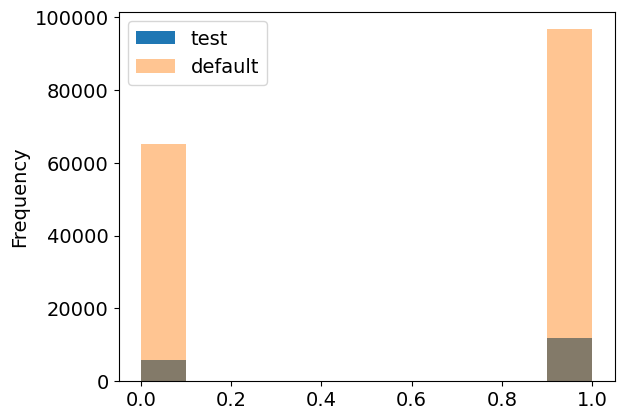

In [128]:
test_bounce.plot(kind='hist', alpha=1, legend=True, label='test')
default_bounce.plot(kind='hist', alpha=0.45, legend=True, label='default');

In [129]:

alpha = 0.05  

zscore, pvalue = proportions_ztest([sum(test_bounce), sum(default_bounce)], [len(test_bounce), len(default_bounce)],
                                   alternative = 'two-sided')
print('zscore = {:.4f}, pvalue = {:.4e}'.format(zscore, pvalue))

if pvalue <= alpha:
    print('The test result is statistically significant.')
    if test_bounce.mean() > default_bounce.mean():
        print('The landing page bounce rate increased in the test group.')
    else:
        print('The landing page bounce rate in the test group did not increase.')
else:
    print('Failed to reject the null hypothesis of equal outcomes and did not obtain a statistically significant result.')

zscore = 19.8415, pvalue = 1.3050e-87
The test result is statistically significant.
The landing page bounce rate increased in the test group.


#### Conversion to Add to Cart

##### default

In [132]:
default

,hit_at,anonymous_id,group,device_type,browser,os
467677,2020-11-26 00:00:10.318 UTC,8fe5810d-905c-462d-944b-66921878fa7d,default,mobile,Chrome WebView,Android
432135,2020-11-26 00:00:17.474 UTC,3ce00502-94c0-41c8-8165-20ea6d2ecd73,default,mobile,Mobile Safari,iOS
250308,2020-11-26 00:00:19.951 UTC,e9030181-192e-4636-9691-2ba4d1eeabb2,default,desktop,Chrome,Windows
489342,2020-11-26 00:00:24.159 UTC,20e24ee6-e40e-4f9a-9631-7db36332c734,default,mobile,Samsung Browser,Android
144584,2020-11-26 00:00:25.857 UTC,e9480708-34a6-4356-8e65-b39664875cb9,default,mobile,Chrome,Android
...,...,...,...,...,...,...
30732,2020-12-10 23:59:18.618 UTC,5e518207-82fb-48b9-9764-c167e84dc57c,default,desktop,Chrome,Linux
430450,2020-12-10 23:59:35.345 UTC,90b60ec1-4d0e-4fab-8cf0-6c5c128ea5ec,default,mobile,Mobile Safari,iOS
35510,2020-12-10 23:59:36.293 UTC,454c7515-0a58-4822-a431-d271e91da190,default,desktop,Chrome,Linux
199014,2020-12-10 23:59:48.461 UTC,ad4b596b-88d3-41e9-969a-7d988039405b,default,desktop,Chrome,Windows


In [133]:

added_grouped = product_added.groupby('anonymous_id', as_index=False).agg(lambda x: list(x)) \
    .rename(columns={'timestamp': 'product_added'})

added_grouped

,anonymous_id,product_added
0,00000782-154a-4159-ab12-6c34b658e375,"[2020-11-29 08:36:59.486 UTC, 2020-11-29 08:38..."
1,00021d91-c65e-4049-9ae1-7d64702c8c12,"[2020-12-01 08:27:56.618 UTC, 2020-12-01 08:39..."
2,0003ca8f-bb3f-4954-84c7-1fbf2353a454,"[2020-11-27 15:36:24.14 UTC, 2020-11-27 15:37:..."
3,0004225d-57d6-44af-8f41-93958b41fbc4,"[2020-12-16 10:26:33.596 UTC, 2020-12-16 10:25..."
4,00048409-3554-4049-907b-88401056d5b0,"[2020-12-04 10:39:17.66 UTC, 2020-12-04 10:35:..."
...,...,...
44118,fffbbed0-9af0-436d-b6de-4d530c9f7112,"[2020-12-06 14:09:21.552 UTC, 2020-12-06 14:40..."
44119,fffdff7b-8f24-4c0d-a1e5-0342941fedf3,[2020-11-27 13:39:00.143 UTC]
44120,fffec437-954e-423e-8b01-050c1f787377,"[2020-12-02 16:00:04.084 UTC, 2020-12-02 15:59..."
44121,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,"[2020-12-05 14:38:46.4 UTC, 2020-12-13 14:54:4..."


In [134]:

added_grouped['product_added_cnt'] = added_grouped.product_added.apply(lambda x: len(x))

added_grouped = added_grouped.sort_values('product_added_cnt', ascending=False).reset_index(drop=True)

added_grouped

,anonymous_id,product_added,product_added_cnt
0,3e5732f3-b0fb-4c1f-8bed-dd7a68994585,"[2020-12-16 17:39:36.073 UTC, 2020-12-10 23:38...",1031
1,ae52ad7a-075a-4e5d-8cd3-d09d72822a8d,"[2020-11-28 07:34:46.043 UTC, 2020-11-26 07:04...",953
2,2bec5d04-635a-4c36-a4ee-2e1dfa7f04d1,"[2020-11-27 13:35:14.855 UTC, 2020-11-28 07:48...",779
3,cc5ae342-601e-40e0-ae49-d60aaada414f,"[2020-12-16 18:34:45.114 UTC, 2020-12-14 18:20...",709
4,49bf3b2d-8c91-43f9-a5df-5b0643290dba,"[2020-12-14 19:23:14.19 UTC, 2020-12-14 19:22:...",670
...,...,...,...
44118,7adaccb9-2dc6-4205-ad74-f0dccc9f33a9,[2020-12-04 20:22:15.112 UTC],1
44119,d055ebdd-fb77-464d-9362-f0c703e6caf7,[2020-12-14 05:08:53.073 UTC],1
44120,3c41e414-b6d1-463a-bb83-2c7f74509968,[2020-12-06 12:06:39.258 UTC],1
44121,d0503955-a20a-4449-8da0-fa8fac42ddf4,[2020-12-06 19:14:00.428 UTC],1


In [135]:

added_grouped.product_added_cnt.describe()

count    44123.000000
mean        26.064864
std         38.475931
min          1.000000
25%          3.000000
50%         14.000000
75%         33.000000
max       1031.000000
Name: product_added_cnt, dtype: float64

In [136]:
# product added merge
default_added = default.merge(added_grouped, on='anonymous_id', how='left')

default_added

,hit_at,anonymous_id,group,device_type,browser,os,product_added,product_added_cnt
0,2020-11-26 00:00:10.318 UTC,8fe5810d-905c-462d-944b-66921878fa7d,default,mobile,Chrome WebView,Android,NaN,NaN
1,2020-11-26 00:00:17.474 UTC,3ce00502-94c0-41c8-8165-20ea6d2ecd73,default,mobile,Mobile Safari,iOS,NaN,NaN
2,2020-11-26 00:00:19.951 UTC,e9030181-192e-4636-9691-2ba4d1eeabb2,default,desktop,Chrome,Windows,NaN,NaN
3,2020-11-26 00:00:24.159 UTC,20e24ee6-e40e-4f9a-9631-7db36332c734,default,mobile,Samsung Browser,Android,NaN,NaN
4,2020-11-26 00:00:25.857 UTC,e9480708-34a6-4356-8e65-b39664875cb9,default,mobile,Chrome,Android,NaN,NaN
...,...,...,...,...,...,...,...,...
434194,2020-12-10 23:59:18.618 UTC,5e518207-82fb-48b9-9764-c167e84dc57c,default,desktop,Chrome,Linux,NaN,NaN
434195,2020-12-10 23:59:35.345 UTC,90b60ec1-4d0e-4fab-8cf0-6c5c128ea5ec,default,mobile,Mobile Safari,iOS,NaN,NaN
434196,2020-12-10 23:59:36.293 UTC,454c7515-0a58-4822-a431-d271e91da190,default,desktop,Chrome,Linux,NaN,NaN
434197,2020-12-10 23:59:48.461 UTC,ad4b596b-88d3-41e9-969a-7d988039405b,default,desktop,Chrome,Windows,NaN,NaN


In [137]:
default_added['product_added'].fillna(0, inplace=True)

C:\Users\sunai\AppData\Local\Temp\ipykernel_77668\2746821049.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  default_added['product_added'].fillna(0, inplace=True)


In [138]:

default_added['conversion'] = default_added['product_added'].apply(lambda x: 0 if x == 0 else 1)

default_added

,hit_at,anonymous_id,group,device_type,browser,os,product_added,product_added_cnt,conversion
0,2020-11-26 00:00:10.318 UTC,8fe5810d-905c-462d-944b-66921878fa7d,default,mobile,Chrome WebView,Android,0,NaN,0
1,2020-11-26 00:00:17.474 UTC,3ce00502-94c0-41c8-8165-20ea6d2ecd73,default,mobile,Mobile Safari,iOS,0,NaN,0
2,2020-11-26 00:00:19.951 UTC,e9030181-192e-4636-9691-2ba4d1eeabb2,default,desktop,Chrome,Windows,0,NaN,0
3,2020-11-26 00:00:24.159 UTC,20e24ee6-e40e-4f9a-9631-7db36332c734,default,mobile,Samsung Browser,Android,0,NaN,0
4,2020-11-26 00:00:25.857 UTC,e9480708-34a6-4356-8e65-b39664875cb9,default,mobile,Chrome,Android,0,NaN,0
...,...,...,...,...,...,...,...,...,...
434194,2020-12-10 23:59:18.618 UTC,5e518207-82fb-48b9-9764-c167e84dc57c,default,desktop,Chrome,Linux,0,NaN,0
434195,2020-12-10 23:59:35.345 UTC,90b60ec1-4d0e-4fab-8cf0-6c5c128ea5ec,default,mobile,Mobile Safari,iOS,0,NaN,0
434196,2020-12-10 23:59:36.293 UTC,454c7515-0a58-4822-a431-d271e91da190,default,desktop,Chrome,Linux,0,NaN,0
434197,2020-12-10 23:59:48.461 UTC,ad4b596b-88d3-41e9-969a-7d988039405b,default,desktop,Chrome,Windows,0,NaN,0


In [139]:
round(default_added.conversion.value_counts(normalize=True)[1] * 100, 2)

8.92

##### test

In [141]:
test

,hit_at,anonymous_id,group,device_type,browser,os
45810,2020-11-26 00:00:19.02 UTC,64f2ed52-52be-4171-917f-1834c0f736f2,address_first,desktop,Chrome,Linux
38251,2020-11-26 00:04:16.775 UTC,48e03311-f213-4b63-b2f9-ff2508b54a03,address_first,desktop,Chrome,Linux
59377,2020-11-26 00:04:58.764 UTC,85932680-44e5-4fd2-88dd-03167615f424,address_first,desktop,Chrome,Linux
43073,2020-11-26 00:05:18.216 UTC,a4ea1971-f41e-4943-921e-5142c7173ef1,address_first,desktop,Chrome,Linux
59378,2020-11-26 00:08:29.442 UTC,3543a788-6bc4-448e-9e97-ac5da585d7a4,address_first,desktop,Chrome,Linux
...,...,...,...,...,...,...
127029,2020-12-10 23:51:19.562 UTC,7f0a4f10-c49c-45a2-bb9e-92b4877b06eb,address_first,mobile,Chrome,Android
266369,2020-12-10 23:54:32.255 UTC,44eda551-929a-4891-b532-0aca11464a28,address_first,desktop,Chrome,Windows
490622,2020-12-10 23:56:33.386 UTC,993e5445-b06f-411a-80ef-818a6cd584d9,address_first,mobile,Samsung Browser,Android
485423,2020-12-10 23:57:47.998 UTC,d4ed11c9-e4e2-4781-bc1b-815bc8ae2608,address_first,mobile,Chrome WebView,Android


In [142]:
# product added merge
test_added = test.merge(added_grouped, on='anonymous_id', how='left')

test_added

,hit_at,anonymous_id,group,device_type,browser,os,product_added,product_added_cnt
0,2020-11-26 00:00:19.02 UTC,64f2ed52-52be-4171-917f-1834c0f736f2,address_first,desktop,Chrome,Linux,NaN,NaN
1,2020-11-26 00:04:16.775 UTC,48e03311-f213-4b63-b2f9-ff2508b54a03,address_first,desktop,Chrome,Linux,NaN,NaN
2,2020-11-26 00:04:58.764 UTC,85932680-44e5-4fd2-88dd-03167615f424,address_first,desktop,Chrome,Linux,NaN,NaN
3,2020-11-26 00:05:18.216 UTC,a4ea1971-f41e-4943-921e-5142c7173ef1,address_first,desktop,Chrome,Linux,NaN,NaN
4,2020-11-26 00:08:29.442 UTC,3543a788-6bc4-448e-9e97-ac5da585d7a4,address_first,desktop,Chrome,Linux,NaN,NaN
...,...,...,...,...,...,...,...,...
54287,2020-12-10 23:51:19.562 UTC,7f0a4f10-c49c-45a2-bb9e-92b4877b06eb,address_first,mobile,Chrome,Android,NaN,NaN
54288,2020-12-10 23:54:32.255 UTC,44eda551-929a-4891-b532-0aca11464a28,address_first,desktop,Chrome,Windows,NaN,NaN
54289,2020-12-10 23:56:33.386 UTC,993e5445-b06f-411a-80ef-818a6cd584d9,address_first,mobile,Samsung Browser,Android,NaN,NaN
54290,2020-12-10 23:57:47.998 UTC,d4ed11c9-e4e2-4781-bc1b-815bc8ae2608,address_first,mobile,Chrome WebView,Android,NaN,NaN


In [143]:
test_added['product_added'].fillna(0, inplace=True)

C:\Users\sunai\AppData\Local\Temp\ipykernel_77668\4072377043.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_added['product_added'].fillna(0, inplace=True)


In [144]:
test_added['conversion'] = test_added['product_added'].apply(lambda x: 0 if x == 0 else 1)

test_added

,hit_at,anonymous_id,group,device_type,browser,os,product_added,product_added_cnt,conversion
0,2020-11-26 00:00:19.02 UTC,64f2ed52-52be-4171-917f-1834c0f736f2,address_first,desktop,Chrome,Linux,0,NaN,0
1,2020-11-26 00:04:16.775 UTC,48e03311-f213-4b63-b2f9-ff2508b54a03,address_first,desktop,Chrome,Linux,0,NaN,0
2,2020-11-26 00:04:58.764 UTC,85932680-44e5-4fd2-88dd-03167615f424,address_first,desktop,Chrome,Linux,0,NaN,0
3,2020-11-26 00:05:18.216 UTC,a4ea1971-f41e-4943-921e-5142c7173ef1,address_first,desktop,Chrome,Linux,0,NaN,0
4,2020-11-26 00:08:29.442 UTC,3543a788-6bc4-448e-9e97-ac5da585d7a4,address_first,desktop,Chrome,Linux,0,NaN,0
...,...,...,...,...,...,...,...,...,...
54287,2020-12-10 23:51:19.562 UTC,7f0a4f10-c49c-45a2-bb9e-92b4877b06eb,address_first,mobile,Chrome,Android,0,NaN,0
54288,2020-12-10 23:54:32.255 UTC,44eda551-929a-4891-b532-0aca11464a28,address_first,desktop,Chrome,Windows,0,NaN,0
54289,2020-12-10 23:56:33.386 UTC,993e5445-b06f-411a-80ef-818a6cd584d9,address_first,mobile,Samsung Browser,Android,0,NaN,0
54290,2020-12-10 23:57:47.998 UTC,d4ed11c9-e4e2-4781-bc1b-815bc8ae2608,address_first,mobile,Chrome WebView,Android,0,NaN,0


In [145]:
round(test_added.conversion.value_counts(normalize=True)[1] * 100, 2)

9.87

##### Conversion rate AB-test

In [147]:
test_cr = test_added.conversion

In [148]:
default_cr = default_added.conversion

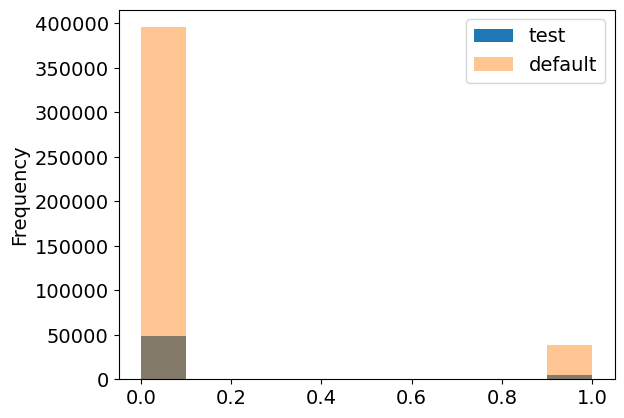

In [149]:
test_cr.plot(kind='hist', alpha=1, legend=True, label='test')
default_cr.plot(kind='hist', alpha=0.45, legend=True, label='default');

In [150]:
alpha = 0.05  

zscore, pvalue = proportions_ztest([sum(test_cr), sum(default_cr)], [len(test_cr), len(default_cr)],
                                   alternative = 'two-sided')
print('zscore = {:.4f}, pvalue = {:.4e}'.format(zscore, pvalue))

if pvalue <= alpha:
    print('The test result is statistically significant.')
    if test_cr.mean() > default_cr.mean():
        print('Succeeded in increasing conversion.')
    else:
        print('Failed to increase conversion.')
else:
    print('Failed to reject the null hypothesis of equal outcomes and did not obtain a statistically significant result.')

zscore = 7.2477, pvalue = 4.2389e-13
The test result is statistically significant.
Succeeded in increasing conversion.


#### Number of items added

##### test

In [153]:
test_added

,hit_at,anonymous_id,group,device_type,browser,os,product_added,product_added_cnt,conversion
0,2020-11-26 00:00:19.02 UTC,64f2ed52-52be-4171-917f-1834c0f736f2,address_first,desktop,Chrome,Linux,0,NaN,0
1,2020-11-26 00:04:16.775 UTC,48e03311-f213-4b63-b2f9-ff2508b54a03,address_first,desktop,Chrome,Linux,0,NaN,0
2,2020-11-26 00:04:58.764 UTC,85932680-44e5-4fd2-88dd-03167615f424,address_first,desktop,Chrome,Linux,0,NaN,0
3,2020-11-26 00:05:18.216 UTC,a4ea1971-f41e-4943-921e-5142c7173ef1,address_first,desktop,Chrome,Linux,0,NaN,0
4,2020-11-26 00:08:29.442 UTC,3543a788-6bc4-448e-9e97-ac5da585d7a4,address_first,desktop,Chrome,Linux,0,NaN,0
...,...,...,...,...,...,...,...,...,...
54287,2020-12-10 23:51:19.562 UTC,7f0a4f10-c49c-45a2-bb9e-92b4877b06eb,address_first,mobile,Chrome,Android,0,NaN,0
54288,2020-12-10 23:54:32.255 UTC,44eda551-929a-4891-b532-0aca11464a28,address_first,desktop,Chrome,Windows,0,NaN,0
54289,2020-12-10 23:56:33.386 UTC,993e5445-b06f-411a-80ef-818a6cd584d9,address_first,mobile,Samsung Browser,Android,0,NaN,0
54290,2020-12-10 23:57:47.998 UTC,d4ed11c9-e4e2-4781-bc1b-815bc8ae2608,address_first,mobile,Chrome WebView,Android,0,NaN,0


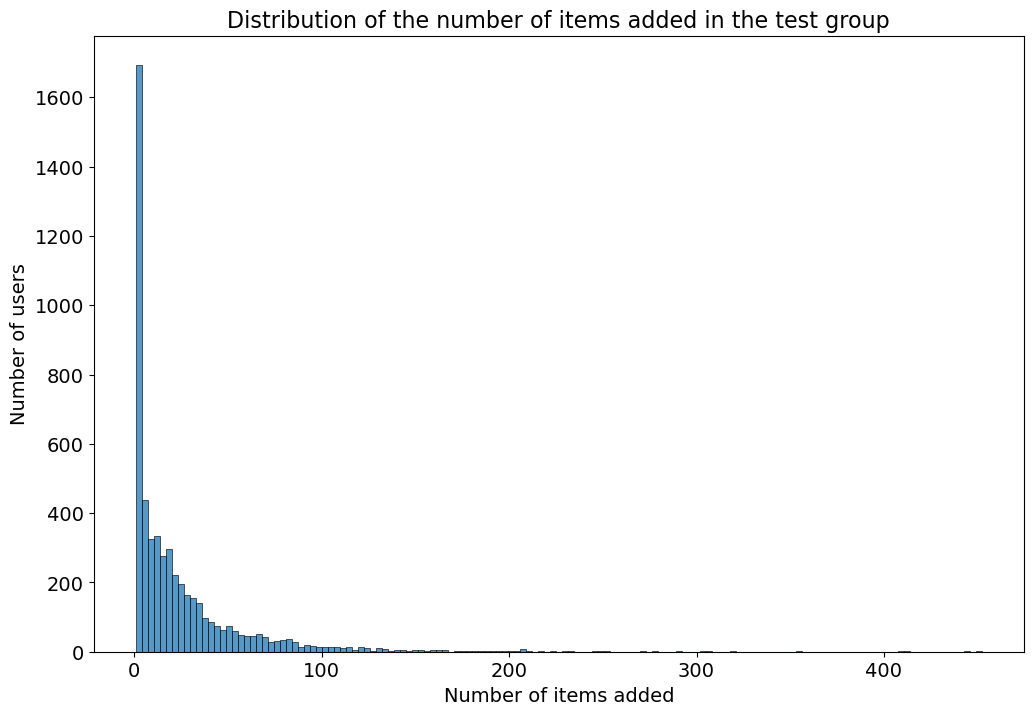

In [154]:

plt.figure(figsize=(12, 8))
ax = sns.histplot(data=test_added, x='product_added_cnt')

ax.set_xlabel('Number of items added',fontsize=14)
ax.set_ylabel('Number of users',fontsize=14)
ax.set_title('Distribution of the number of items added in the test group', fontsize=16);

plt.savefig('test_cnt.png')

In [155]:
test_added['product_cnt_log'] = test_added['product_added_cnt'].apply(lambda x: np.log(x))

test_added

,hit_at,anonymous_id,group,device_type,browser,os,product_added,product_added_cnt,conversion,product_cnt_log
0,2020-11-26 00:00:19.02 UTC,64f2ed52-52be-4171-917f-1834c0f736f2,address_first,desktop,Chrome,Linux,0,NaN,0,NaN
1,2020-11-26 00:04:16.775 UTC,48e03311-f213-4b63-b2f9-ff2508b54a03,address_first,desktop,Chrome,Linux,0,NaN,0,NaN
2,2020-11-26 00:04:58.764 UTC,85932680-44e5-4fd2-88dd-03167615f424,address_first,desktop,Chrome,Linux,0,NaN,0,NaN
3,2020-11-26 00:05:18.216 UTC,a4ea1971-f41e-4943-921e-5142c7173ef1,address_first,desktop,Chrome,Linux,0,NaN,0,NaN
4,2020-11-26 00:08:29.442 UTC,3543a788-6bc4-448e-9e97-ac5da585d7a4,address_first,desktop,Chrome,Linux,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...
54287,2020-12-10 23:51:19.562 UTC,7f0a4f10-c49c-45a2-bb9e-92b4877b06eb,address_first,mobile,Chrome,Android,0,NaN,0,NaN
54288,2020-12-10 23:54:32.255 UTC,44eda551-929a-4891-b532-0aca11464a28,address_first,desktop,Chrome,Windows,0,NaN,0,NaN
54289,2020-12-10 23:56:33.386 UTC,993e5445-b06f-411a-80ef-818a6cd584d9,address_first,mobile,Samsung Browser,Android,0,NaN,0,NaN
54290,2020-12-10 23:57:47.998 UTC,d4ed11c9-e4e2-4781-bc1b-815bc8ae2608,address_first,mobile,Chrome WebView,Android,0,NaN,0,NaN


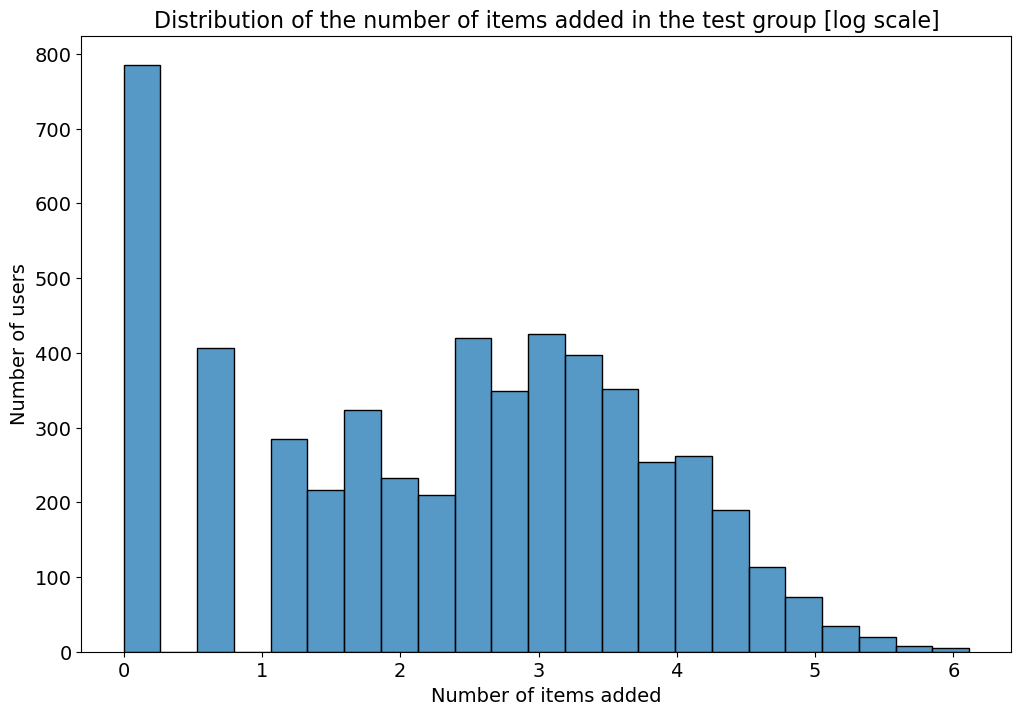

In [156]:

plt.figure(figsize=(12, 8))
ax = sns.histplot(data=test_added, x='product_cnt_log')

ax.set_xlabel('Number of items added',fontsize=14)
ax.set_ylabel('Number of users',fontsize=14)
ax.set_title('Distribution of the number of items added in the test group [log scale]', fontsize=16);

plt.savefig('test_cnt_log.png')

In [157]:

test_cnt_log = test_added.product_cnt_log

In [158]:

temp_t = test_cnt_log.reset_index()

temp_t = temp_t.assign(group = 'test')

In [159]:

result = st.shapiro(test_added[test_added['product_added_cnt'] >= 0].product_added_cnt.sample(1000, random_state=17))  

print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('The distribution is normal')
else:
    print('The distribution is not normal.')

test statistic = 0.6650, pvalue = 2.0564e-40
The distribution is not normal.


In [160]:
result = st.shapiro(temp_t[temp_t['product_cnt_log'] >= 0].product_cnt_log.sample(1000, random_state=17)) 

print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('The distribution is normal.')
else:
    print('The distribution is not normal.')

test statistic = 0.9492, pvalue = 4.5630e-18
The distribution is not normal.


##### default

In [162]:
default_added

,hit_at,anonymous_id,group,device_type,browser,os,product_added,product_added_cnt,conversion
0,2020-11-26 00:00:10.318 UTC,8fe5810d-905c-462d-944b-66921878fa7d,default,mobile,Chrome WebView,Android,0,NaN,0
1,2020-11-26 00:00:17.474 UTC,3ce00502-94c0-41c8-8165-20ea6d2ecd73,default,mobile,Mobile Safari,iOS,0,NaN,0
2,2020-11-26 00:00:19.951 UTC,e9030181-192e-4636-9691-2ba4d1eeabb2,default,desktop,Chrome,Windows,0,NaN,0
3,2020-11-26 00:00:24.159 UTC,20e24ee6-e40e-4f9a-9631-7db36332c734,default,mobile,Samsung Browser,Android,0,NaN,0
4,2020-11-26 00:00:25.857 UTC,e9480708-34a6-4356-8e65-b39664875cb9,default,mobile,Chrome,Android,0,NaN,0
...,...,...,...,...,...,...,...,...,...
434194,2020-12-10 23:59:18.618 UTC,5e518207-82fb-48b9-9764-c167e84dc57c,default,desktop,Chrome,Linux,0,NaN,0
434195,2020-12-10 23:59:35.345 UTC,90b60ec1-4d0e-4fab-8cf0-6c5c128ea5ec,default,mobile,Mobile Safari,iOS,0,NaN,0
434196,2020-12-10 23:59:36.293 UTC,454c7515-0a58-4822-a431-d271e91da190,default,desktop,Chrome,Linux,0,NaN,0
434197,2020-12-10 23:59:48.461 UTC,ad4b596b-88d3-41e9-969a-7d988039405b,default,desktop,Chrome,Windows,0,NaN,0


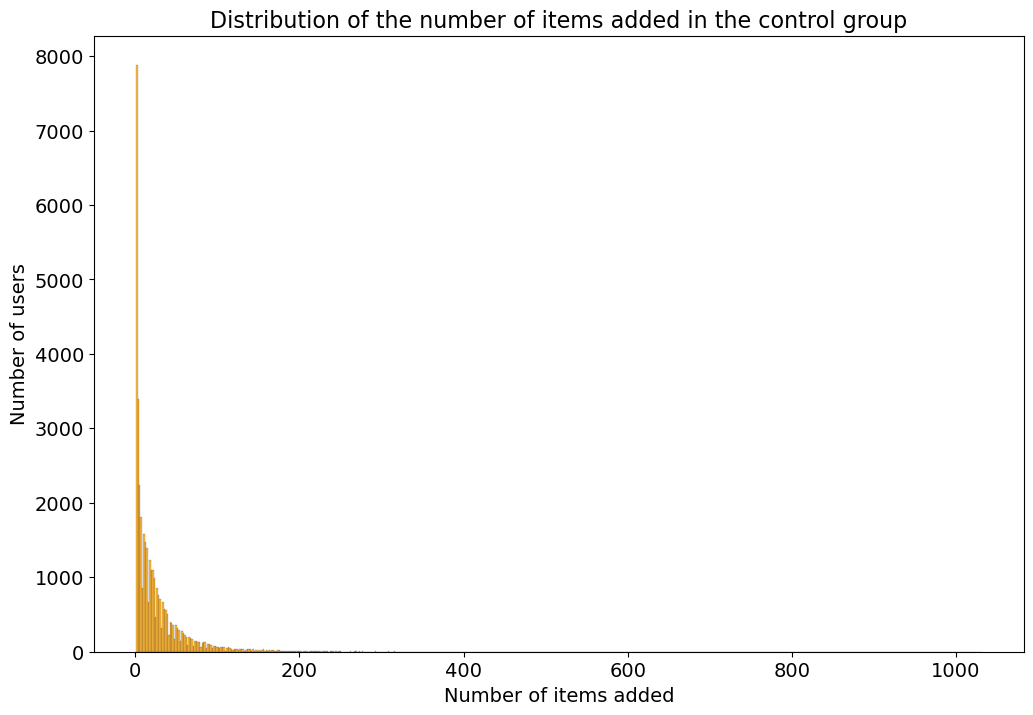

In [163]:
plt.figure(figsize=(12, 8))
ax = sns.histplot(data=default_added, x='product_added_cnt', color='orange')

ax.set_xlabel('Number of items added',fontsize=14)
ax.set_ylabel('Number of users',fontsize=14)
ax.set_title('Distribution of the number of items added in the control group', fontsize=16);

plt.savefig('default_cnt.png')

In [164]:
default_added['product_cnt_log'] = default_added['product_added_cnt'].apply(lambda x: np.log(x))

default_added

,hit_at,anonymous_id,group,device_type,browser,os,product_added,product_added_cnt,conversion,product_cnt_log
0,2020-11-26 00:00:10.318 UTC,8fe5810d-905c-462d-944b-66921878fa7d,default,mobile,Chrome WebView,Android,0,NaN,0,NaN
1,2020-11-26 00:00:17.474 UTC,3ce00502-94c0-41c8-8165-20ea6d2ecd73,default,mobile,Mobile Safari,iOS,0,NaN,0,NaN
2,2020-11-26 00:00:19.951 UTC,e9030181-192e-4636-9691-2ba4d1eeabb2,default,desktop,Chrome,Windows,0,NaN,0,NaN
3,2020-11-26 00:00:24.159 UTC,20e24ee6-e40e-4f9a-9631-7db36332c734,default,mobile,Samsung Browser,Android,0,NaN,0,NaN
4,2020-11-26 00:00:25.857 UTC,e9480708-34a6-4356-8e65-b39664875cb9,default,mobile,Chrome,Android,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...
434194,2020-12-10 23:59:18.618 UTC,5e518207-82fb-48b9-9764-c167e84dc57c,default,desktop,Chrome,Linux,0,NaN,0,NaN
434195,2020-12-10 23:59:35.345 UTC,90b60ec1-4d0e-4fab-8cf0-6c5c128ea5ec,default,mobile,Mobile Safari,iOS,0,NaN,0,NaN
434196,2020-12-10 23:59:36.293 UTC,454c7515-0a58-4822-a431-d271e91da190,default,desktop,Chrome,Linux,0,NaN,0,NaN
434197,2020-12-10 23:59:48.461 UTC,ad4b596b-88d3-41e9-969a-7d988039405b,default,desktop,Chrome,Windows,0,NaN,0,NaN


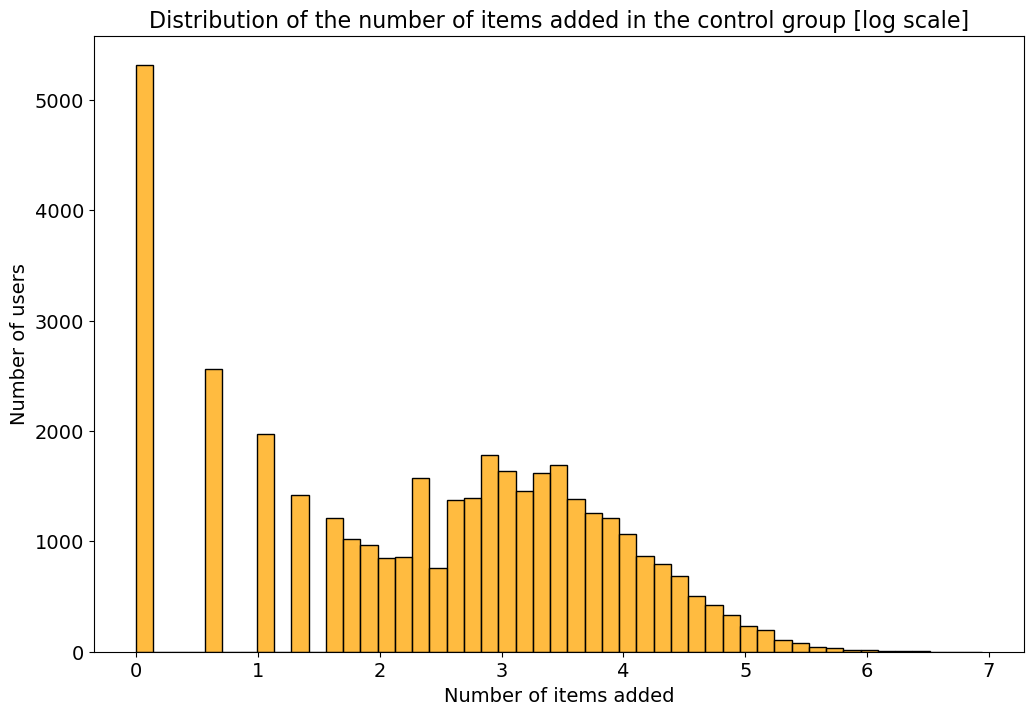

In [165]:
plt.figure(figsize=(12, 8))
ax = sns.histplot(data=default_added, x='product_cnt_log', color='orange')

ax.set_xlabel('Number of items added',fontsize=14)
ax.set_ylabel('Number of users',fontsize=14)
ax.set_title('Distribution of the number of items added in the control group [log scale]', fontsize=16);

plt.savefig('default_cnt_log.png')

In [166]:
default_cnt_log = default_added.product_cnt_log

In [167]:
temp_d = default_cnt_log.reset_index()
temp_d = temp_d.assign(group = 'default')

In [168]:

result = st.shapiro(default_added[default_added['product_added_cnt'] >= 0].product_added_cnt.sample(1000, random_state=17))  

print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('The distribution is normal.')
else:
    print('The distribution is not normal.')

test statistic = 0.6835, pvalue = 1.3261e-39
The distribution is not normal.


In [169]:
result = st.shapiro(temp_d[temp_d['product_cnt_log'] >= 0].product_cnt_log.sample(1000, random_state=17))  

print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('The distribution is normal')
else:
    print('The distribution is not normal.')

test statistic = 0.9490, pvalue = 4.1007e-18
The distribution is not normal.


In [170]:
temp = pd.concat([temp_d, temp_t])

temp

,index,product_cnt_log,group
0,0,NaN,default
1,1,NaN,default
2,2,NaN,default
3,3,NaN,default
4,4,NaN,default
...,...,...,...
54287,54287,NaN,test
54288,54288,NaN,test
54289,54289,NaN,test
54290,54290,NaN,test


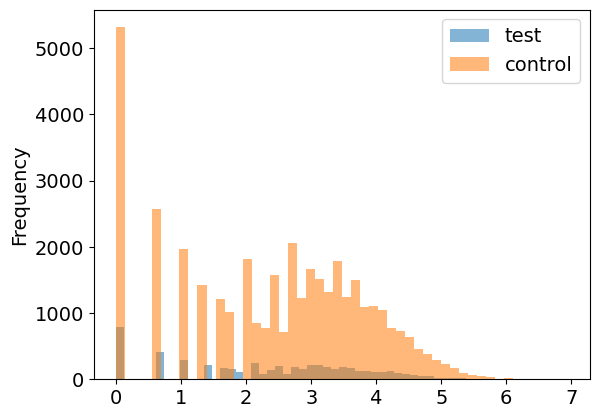

In [171]:

test_cnt_log.plot(kind='hist', alpha=0.55, legend=True, label='test', bins=50)
default_cnt_log.plot(kind='hist', alpha=0.55, legend=True, label='control', bins=50);

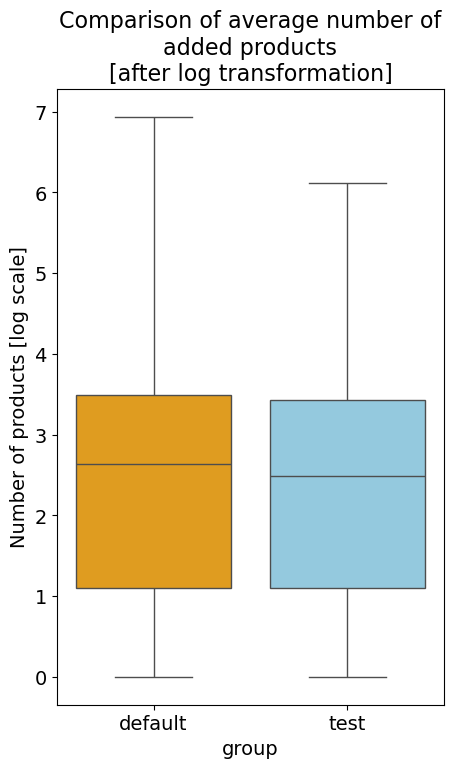

In [172]:
# Clean the data
temp = temp.loc[:, ~temp.columns.duplicated()]  # Remove duplicate columns
temp = temp.reset_index(drop=True)             # Reset index to avoid duplicates

# Set figure size and color palette
plt.figure(figsize=(5, 8))
my_pal = ['orange', 'skyblue']

# Draw the boxplot, using hue='group' to avoid FutureWarning
ax = sns.boxplot(data=temp, y='product_cnt_log', x='group', hue='group', palette=my_pal, legend=False)

# Set title and axis labels
ax.set_title('Comparison of average number of\nadded products\n[after log transformation]', fontsize=16)
ax.set_ylabel('Number of products [log scale]', fontsize=14)

# Save the plot
plt.savefig('boxplot_cnt_log2.png')
plt.show()

#### AB-test Number of Added Products

In [174]:

alpha = 0.05

result = st.mannwhitneyu(temp_d[temp_d['product_cnt_log'] >= 0].product_cnt_log,
                      temp_t[temp_t['product_cnt_log'] >= 0].product_cnt_log,
                      alternative='two-sided')

print('U statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result.pvalue < 0.05:
    print('We reject the null hypothesis of equal means of the two samples.')
    if temp_t[temp_t['product_cnt_log'] >= 0].product_cnt_log.mean() >temp_d[temp_d['product_cnt_log'] >= 0].product_cnt_log.mean():
        print('Succeeded in increasing the number of items added to the cart.')
    else:
        print('Failed to increase the number of items added to the cart.')
else:
    print('We do not have enough evidence to reject the null hypothesis and accept the alternative.')

U statistic = 107097905.0000, pvalue = 1.5416e-04
We reject the null hypothesis of equal means of the two samples.
Failed to increase the number of items added to the cart.


#### Speed of adding items to the cart

##### test

In [177]:
test_lw

,anonymous_id,hit_at,landing_viewed,landing_view_cnt
0,6368eb82-d361-4aca-869e-080f167e3b5f,2020-12-01 00:57:15.357 UTC,"[2020-12-01 00:57:47.439 UTC, 2020-12-01 01:13...",532
1,8da49d4a-48a7-4e27-8a16-5d122c9602c4,2020-12-02 17:14:50.225 UTC,"[2020-12-08 15:26:04.107 UTC, 2020-12-08 16:05...",126
2,43565189-ddcb-4d0e-981c-91eb105ee2aa,2020-12-03 07:43:42.571 UTC,"[2020-12-10 17:37:24.233 UTC, 2020-12-11 19:27...",83
3,f20faf0a-75c6-41d4-a12e-472ce3b923b8,2020-11-27 18:11:49.984 UTC,"[2020-12-12 19:01:52.862 UTC, 2020-12-13 19:27...",47
4,cedad510-b65c-4077-82b2-88b020e62f79,2020-11-26 20:37:53.819 UTC,"[2020-11-27 06:46:01.309 UTC, 2020-11-27 07:36...",38
...,...,...,...,...
23545,6117f53f-ed37-443d-be6d-b5bd1d61088d,2020-11-27 18:24:07.506 UTC,[2020-11-27 18:24:07.655 UTC],1
23546,6115517c-bb51-4068-85fb-c64b75638dee,2020-12-03 13:06:01.228 UTC,[2020-12-03 13:06:01.258 UTC],1
23547,6114feb3-5192-47ab-a61b-4f45a33646f7,2020-12-03 08:05:17.151 UTC,[2020-12-03 08:07:15.844 UTC],1
23548,611386ec-1212-4e3c-8569-61d6ac055e8f,2020-11-26 13:46:18.473 UTC,[2020-11-26 13:46:18.473 UTC],1


In [178]:
test_2 = test[['hit_at', 'anonymous_id']]

test_2

,hit_at,anonymous_id
45810,2020-11-26 00:00:19.02 UTC,64f2ed52-52be-4171-917f-1834c0f736f2
38251,2020-11-26 00:04:16.775 UTC,48e03311-f213-4b63-b2f9-ff2508b54a03
59377,2020-11-26 00:04:58.764 UTC,85932680-44e5-4fd2-88dd-03167615f424
43073,2020-11-26 00:05:18.216 UTC,a4ea1971-f41e-4943-921e-5142c7173ef1
59378,2020-11-26 00:08:29.442 UTC,3543a788-6bc4-448e-9e97-ac5da585d7a4
...,...,...
127029,2020-12-10 23:51:19.562 UTC,7f0a4f10-c49c-45a2-bb9e-92b4877b06eb
266369,2020-12-10 23:54:32.255 UTC,44eda551-929a-4891-b532-0aca11464a28
490622,2020-12-10 23:56:33.386 UTC,993e5445-b06f-411a-80ef-818a6cd584d9
485423,2020-12-10 23:57:47.998 UTC,d4ed11c9-e4e2-4781-bc1b-815bc8ae2608


In [179]:
test_2_lw = test_2.merge(landing_v, on='anonymous_id', how='left') \
    .rename(columns={'timestamp': 'landing_time'})

test_2_lw

,hit_at,anonymous_id,landing_time
0,2020-11-26 00:00:19.02 UTC,64f2ed52-52be-4171-917f-1834c0f736f2,2020-11-26 00:00:19.019 UTC
1,2020-11-26 00:04:16.775 UTC,48e03311-f213-4b63-b2f9-ff2508b54a03,2020-11-26 00:04:16.776 UTC
2,2020-11-26 00:04:58.764 UTC,85932680-44e5-4fd2-88dd-03167615f424,2020-11-26 00:04:58.765 UTC
3,2020-11-26 00:05:18.216 UTC,a4ea1971-f41e-4943-921e-5142c7173ef1,2020-11-26 00:05:18.216 UTC
4,2020-11-26 00:08:29.442 UTC,3543a788-6bc4-448e-9e97-ac5da585d7a4,2020-11-26 00:08:29.457 UTC
...,...,...,...
66297,2020-12-10 23:51:19.562 UTC,7f0a4f10-c49c-45a2-bb9e-92b4877b06eb,2020-12-10 23:51:19.562 UTC
66298,2020-12-10 23:54:32.255 UTC,44eda551-929a-4891-b532-0aca11464a28,NaN
66299,2020-12-10 23:56:33.386 UTC,993e5445-b06f-411a-80ef-818a6cd584d9,NaN
66300,2020-12-10 23:57:47.998 UTC,d4ed11c9-e4e2-4781-bc1b-815bc8ae2608,NaN


In [180]:
test2_lw_grouped = test_2_lw.groupby(['anonymous_id', 'landing_time'], as_index=False).agg({'hit_at' : 'count'}) \
    .sort_values(['anonymous_id', 'landing_time'], ascending=True)

test2_lw_grouped

,anonymous_id,landing_time,hit_at
0,0006c4b0-ce48-4294-8027-8f22e4e3a93b,2020-12-09 11:12:35.485 UTC,1
1,0007e6dd-f368-4108-bd3c-93fd3dc4f880,2020-11-28 09:18:39.728 UTC,1
2,000aad95-885c-4d32-80c1-c53434a17ac9,2020-11-28 11:03:02.111 UTC,1
3,000fda14-fac9-45d1-a6b0-5add620ba0d6,2020-12-09 05:53:57.473 UTC,1
4,000fda14-fac9-45d1-a6b0-5add620ba0d6,2020-12-09 05:54:44.474 UTC,1
...,...,...,...
35555,fff4b7eb-6454-46f0-a598-9f813b443815,2020-12-08 16:03:08.347 UTC,1
35556,fff53aa3-cbdd-4f33-bc8f-1b2842a0426b,2020-12-04 04:32:10.076 UTC,1
35557,fffa7926-b5a3-4533-a737-c6e4f351243b,2020-11-26 15:21:17.315 UTC,1
35558,fffad60a-648b-418b-8d1b-6e714a828faf,2020-12-03 14:11:10.695 UTC,1


In [181]:
test2_lw_grouped[test2_lw_grouped.anonymous_id.duplicated(keep=False)== True]

,anonymous_id,landing_time,hit_at
3,000fda14-fac9-45d1-a6b0-5add620ba0d6,2020-12-09 05:53:57.473 UTC,1
4,000fda14-fac9-45d1-a6b0-5add620ba0d6,2020-12-09 05:54:44.474 UTC,1
7,00170748-1815-494d-86eb-c95fd8ad0de4,2020-11-26 16:14:58.182 UTC,1
8,00170748-1815-494d-86eb-c95fd8ad0de4,2020-11-26 16:15:17.144 UTC,1
9,001de4df-8dc4-4e9e-86a9-d4a9fdae8257,2020-12-10 09:00:13.724 UTC,1
...,...,...,...
35542,ffd2b302-8ce9-4fa0-b761-5fa2ac611edf,2020-12-03 22:13:25.565 UTC,1
35548,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:14:35.284 UTC,1
35549,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:42:08.788 UTC,1
35550,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:43:21.193 UTC,1


In [182]:
pd_added_grouped = product_added.reset_index() \
    .groupby(['anonymous_id', 'timestamp'], as_index=False).agg({'index' : 'count'}) \
    .sort_values(['anonymous_id', 'timestamp'], ascending=True)

pd_added_grouped

,anonymous_id,timestamp,index
0,00000782-154a-4159-ab12-6c34b658e375,2020-11-28 07:50:05.58 UTC,1
1,00000782-154a-4159-ab12-6c34b658e375,2020-11-28 07:50:15.865 UTC,1
2,00000782-154a-4159-ab12-6c34b658e375,2020-11-29 08:23:16.22 UTC,1
3,00000782-154a-4159-ab12-6c34b658e375,2020-11-29 08:26:09.465 UTC,1
4,00000782-154a-4159-ab12-6c34b658e375,2020-11-29 08:26:34.235 UTC,1
...,...,...,...
1150055,ffff5651-7253-4b44-9d35-95d0cdd89622,2020-12-02 07:39:33.915 UTC,1
1150056,ffff5651-7253-4b44-9d35-95d0cdd89622,2020-12-02 07:39:41.419 UTC,1
1150057,ffff5651-7253-4b44-9d35-95d0cdd89622,2020-12-02 07:43:55.574 UTC,1
1150058,ffff5651-7253-4b44-9d35-95d0cdd89622,2020-12-02 07:44:07.568 UTC,1


In [183]:
test2_added = test2_lw_grouped.merge(pd_added_grouped, on='anonymous_id', how='left') \
    .rename(columns={'timestamp': 'added_time'})

test2_added

,anonymous_id,landing_time,hit_at,added_time,index
0,0006c4b0-ce48-4294-8027-8f22e4e3a93b,2020-12-09 11:12:35.485 UTC,1,NaN,NaN
1,0007e6dd-f368-4108-bd3c-93fd3dc4f880,2020-11-28 09:18:39.728 UTC,1,NaN,NaN
2,000aad95-885c-4d32-80c1-c53434a17ac9,2020-11-28 11:03:02.111 UTC,1,NaN,NaN
3,000fda14-fac9-45d1-a6b0-5add620ba0d6,2020-12-09 05:53:57.473 UTC,1,NaN,NaN
4,000fda14-fac9-45d1-a6b0-5add620ba0d6,2020-12-09 05:54:44.474 UTC,1,NaN,NaN
...,...,...,...,...,...
258725,fff4b7eb-6454-46f0-a598-9f813b443815,2020-12-08 16:03:08.347 UTC,1,NaN,NaN
258726,fff53aa3-cbdd-4f33-bc8f-1b2842a0426b,2020-12-04 04:32:10.076 UTC,1,NaN,NaN
258727,fffa7926-b5a3-4533-a737-c6e4f351243b,2020-11-26 15:21:17.315 UTC,1,NaN,NaN
258728,fffad60a-648b-418b-8d1b-6e714a828faf,2020-12-03 14:11:10.695 UTC,1,NaN,NaN


In [184]:
test2_added_filt = test2_added[test2_added['added_time'].isna() == False].drop(columns=['hit_at', 'index'])

test2_added_filt

,anonymous_id,landing_time,added_time
5,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156 UTC,2020-12-09 06:54:33.365 UTC
6,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156 UTC,2020-12-09 06:54:38.136 UTC
7,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156 UTC,2020-12-09 06:58:49.492 UTC
8,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156 UTC,2020-12-09 06:59:52.778 UTC
9,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156 UTC,2020-12-09 07:04:32.726 UTC
...,...,...,...
258714,ffda1621-b553-4b08-89e7-07729ff397c3,2020-12-07 07:39:07.437 UTC,2020-12-07 11:01:16.555 UTC
258718,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:14:35.284 UTC,2020-12-05 07:48:09.183 UTC
258719,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:42:08.788 UTC,2020-12-05 07:48:09.183 UTC
258720,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:43:21.193 UTC,2020-12-05 07:48:09.183 UTC


In [185]:
test2_added_grouped = test2_added_filt.reset_index() \
    .groupby(['anonymous_id', 'landing_time', 'added_time'], as_index=False).agg({'index' : 'count'}) \
    .sort_values(['anonymous_id', 'landing_time', 'added_time'], ascending=True)

test2_added_grouped

,anonymous_id,landing_time,added_time,index
0,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156 UTC,2020-12-09 06:54:33.365 UTC,1
1,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156 UTC,2020-12-09 06:54:38.136 UTC,1
2,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156 UTC,2020-12-09 06:58:49.492 UTC,1
3,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156 UTC,2020-12-09 06:59:52.778 UTC,1
4,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156 UTC,2020-12-09 07:04:32.726 UTC,1
...,...,...,...,...
230172,ffda1621-b553-4b08-89e7-07729ff397c3,2020-12-07 07:39:07.437 UTC,2020-12-07 11:01:16.555 UTC,1
230173,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:14:35.284 UTC,2020-12-05 07:48:09.183 UTC,1
230174,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:42:08.788 UTC,2020-12-05 07:48:09.183 UTC,1
230175,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:43:21.193 UTC,2020-12-05 07:48:09.183 UTC,1


In [186]:
test2_added_dd = test2_added_grouped.drop_duplicates(subset=['landing_time']).drop(columns='index')

test2_added_dd

,anonymous_id,landing_time,added_time
0,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156 UTC,2020-12-09 06:54:33.365 UTC
7,00292def-6714-49fe-940a-5cfda3cbf84b,2020-12-04 20:15:22.398 UTC,2020-12-04 20:16:42.658 UTC
8,0037ebf4-0e14-4880-b6b9-5dec5a70ea66,2020-12-05 06:41:35.454 UTC,2020-12-05 06:44:56.777 UTC
37,004aec46-3e7f-4003-bd37-a665d6acd719,2020-12-04 06:33:52.187 UTC,2020-12-04 06:37:01.533 UTC
41,004aec46-3e7f-4003-bd37-a665d6acd719,2020-12-04 06:36:07.051 UTC,2020-12-04 06:37:01.533 UTC
...,...,...,...
230168,ffda1621-b553-4b08-89e7-07729ff397c3,2020-12-07 07:39:07.437 UTC,2020-12-07 07:42:38.041 UTC
230173,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:14:35.284 UTC,2020-12-05 07:48:09.183 UTC
230174,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:42:08.788 UTC,2020-12-05 07:48:09.183 UTC
230175,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:43:21.193 UTC,2020-12-05 07:48:09.183 UTC


In [187]:
test2_added_dd['added_time'] = pd.to_datetime(test2_added_dd['added_time'], utc=True, errors='coerce')
test2_added_dd['landing_time'] = pd.to_datetime(test2_added_dd['landing_time'], utc=True, errors='coerce')


test2_added_dd['time_delta'] = test2_added_dd['added_time'] - test2_added_dd['landing_time']



In [188]:
test2_added_dd['seconds'] = test2_added_dd.time_delta.dt.total_seconds()

test2_added_dd

,anonymous_id,landing_time,added_time,time_delta,seconds
0,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156000+00:00,2020-12-09 06:54:33.365000+00:00,0 days 00:01:58.209000,118.209
7,00292def-6714-49fe-940a-5cfda3cbf84b,2020-12-04 20:15:22.398000+00:00,2020-12-04 20:16:42.658000+00:00,0 days 00:01:20.260000,80.260
8,0037ebf4-0e14-4880-b6b9-5dec5a70ea66,2020-12-05 06:41:35.454000+00:00,2020-12-05 06:44:56.777000+00:00,0 days 00:03:21.323000,201.323
37,004aec46-3e7f-4003-bd37-a665d6acd719,2020-12-04 06:33:52.187000+00:00,2020-12-04 06:37:01.533000+00:00,0 days 00:03:09.346000,189.346
41,004aec46-3e7f-4003-bd37-a665d6acd719,2020-12-04 06:36:07.051000+00:00,2020-12-04 06:37:01.533000+00:00,0 days 00:00:54.482000,54.482
...,...,...,...,...,...
230168,ffda1621-b553-4b08-89e7-07729ff397c3,2020-12-07 07:39:07.437000+00:00,2020-12-07 07:42:38.041000+00:00,0 days 00:03:30.604000,210.604
230173,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:14:35.284000+00:00,2020-12-05 07:48:09.183000+00:00,0 days 00:33:33.899000,2013.899
230174,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:42:08.788000+00:00,2020-12-05 07:48:09.183000+00:00,0 days 00:06:00.395000,360.395
230175,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:43:21.193000+00:00,2020-12-05 07:48:09.183000+00:00,0 days 00:04:47.990000,287.990


In [189]:
test2_dd_ss = test2_added_dd[test2_added_dd['seconds'] > 0].sort_values('seconds')

test2_dd_ss

,anonymous_id,landing_time,added_time,time_delta,seconds
149366,b178fb5c-68c3-49f7-90a2-dd1b98eb0df2,2020-12-10 09:14:29.225000+00:00,2020-12-10 09:14:47.224000+00:00,0 days 00:00:17.999000,17.999
197535,da99c948-dce1-40fd-bfa8-7c3e26d509ec,2020-11-29 16:10:44.990000+00:00,2020-11-29 16:11:03.355000+00:00,0 days 00:00:18.365000,18.365
59901,470d144c-72ea-4032-8ece-9a9fbf757577,2020-12-06 19:11:44.602000+00:00,2020-12-06 19:12:04.351000+00:00,0 days 00:00:19.749000,19.749
33553,2dc99513-1442-4611-bed2-9920bb0ca8b8,2020-12-07 16:10:33.651000+00:00,2020-12-07 16:10:54.444000+00:00,0 days 00:00:20.793000,20.793
105371,7f4d48bc-3fd1-49fc-a103-b4736d4ceb08,2020-11-26 21:11:09.139000+00:00,2020-11-26 21:11:29.966000+00:00,0 days 00:00:20.827000,20.827
...,...,...,...,...,...
8047,0b495c6f-9bad-485d-89ce-2573febea43f,2020-11-26 12:44:19.713000+00:00,2020-12-17 11:40:18.720000+00:00,20 days 22:55:59.007000,1810559.007
8031,0b495c6f-9bad-485d-89ce-2573febea43f,2020-11-26 12:43:51.492000+00:00,2020-12-17 11:40:18.720000+00:00,20 days 22:56:27.228000,1810587.228
227457,fb0cd8bb-9301-4068-8d0f-e04d2ff08a06,2020-11-26 06:49:39.567000+00:00,2020-12-17 08:43:46.347000+00:00,21 days 01:54:06.780000,1821246.780
123574,91e40c7f-df50-40f4-b53a-89b3ca799049,2020-11-26 05:22:51.483000+00:00,2020-12-17 09:01:35.168000+00:00,21 days 03:38:43.685000,1827523.685


In [190]:
test2_dd_ss.seconds.describe()

count    4.716000e+03
mean     8.190115e+04
std      2.407293e+05
min      1.799900e+01
25%      1.537595e+02
50%      3.401580e+02
75%      2.077238e+03
max      1.837060e+06
Name: seconds, dtype: float64

In [191]:
q1, q3, iqr = iq_range(test2_dd_ss, 'seconds')

In [192]:
test2_dd_ss_f = test2_dd_ss.query('(@q1 - 1.5*@iqr) <= seconds <= (@q3 + 1.5*@iqr)')
test2_dd_ss_f

,anonymous_id,landing_time,added_time,time_delta,seconds
149366,b178fb5c-68c3-49f7-90a2-dd1b98eb0df2,2020-12-10 09:14:29.225000+00:00,2020-12-10 09:14:47.224000+00:00,0 days 00:00:17.999000,17.999
197535,da99c948-dce1-40fd-bfa8-7c3e26d509ec,2020-11-29 16:10:44.990000+00:00,2020-11-29 16:11:03.355000+00:00,0 days 00:00:18.365000,18.365
59901,470d144c-72ea-4032-8ece-9a9fbf757577,2020-12-06 19:11:44.602000+00:00,2020-12-06 19:12:04.351000+00:00,0 days 00:00:19.749000,19.749
33553,2dc99513-1442-4611-bed2-9920bb0ca8b8,2020-12-07 16:10:33.651000+00:00,2020-12-07 16:10:54.444000+00:00,0 days 00:00:20.793000,20.793
105371,7f4d48bc-3fd1-49fc-a103-b4736d4ceb08,2020-11-26 21:11:09.139000+00:00,2020-11-26 21:11:29.966000+00:00,0 days 00:00:20.827000,20.827
...,...,...,...,...,...
162102,be7c47d6-9cf2-4bd3-9b7c-c2ecf1886428,2020-12-02 11:45:46.099000+00:00,2020-12-02 13:02:49.680000+00:00,0 days 01:17:03.581000,4623.581
215172,ec173cdd-4abe-4031-b19c-b4c910a40f54,2020-11-29 10:29:17.535000+00:00,2020-11-29 11:48:19.541000+00:00,0 days 01:19:02.006000,4742.006
120787,8ce6327e-19a9-4705-ba22-735e32583460,2020-12-07 12:47:01.342000+00:00,2020-12-07 14:06:53.408000+00:00,0 days 01:19:52.066000,4792.066
143378,ad2c944b-6925-4d8e-b10b-f65e10912f56,2020-12-09 08:11:05.522000+00:00,2020-12-09 09:31:42.930000+00:00,0 days 01:20:37.408000,4837.408


In [193]:
test2_dd_ss_f.seconds.describe()

count    3686.000000
mean      476.963050
std       680.974656
min        17.999000
25%       127.831750
50%       233.644000
75%       488.305250
max      4861.817000
Name: seconds, dtype: float64

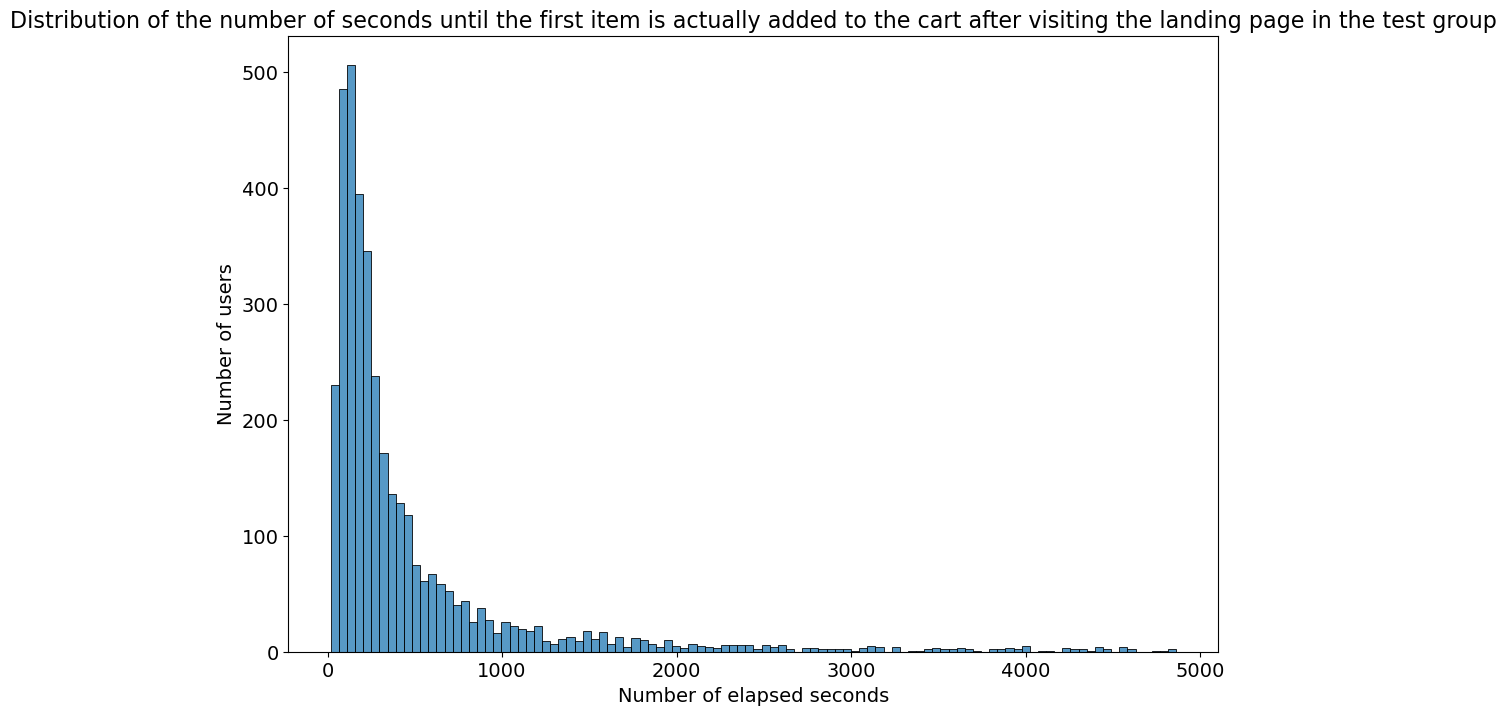

In [194]:

plt.figure(figsize=(12, 8))
ax = sns.histplot(data=test2_dd_ss_f, x='seconds')

ax.set_xlabel('Number of elapsed seconds',fontsize=14)
ax.set_ylabel('Number of users',fontsize=14)
ax.set_title('Distribution of the number of seconds until the first item is actually added to the cart after visiting the landing page in the test group', fontsize=16);

plt.savefig('test_seconds.png')

In [195]:

result = st.shapiro(test2_dd_ss_f.seconds.sample(1000, random_state=17))  

print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('The distribution is normal')
else:
    print('The distribution is not normal')

test statistic = 0.5920, pvalue = 2.7200e-43
The distribution is not normal


<Axes: ylabel='seconds'>

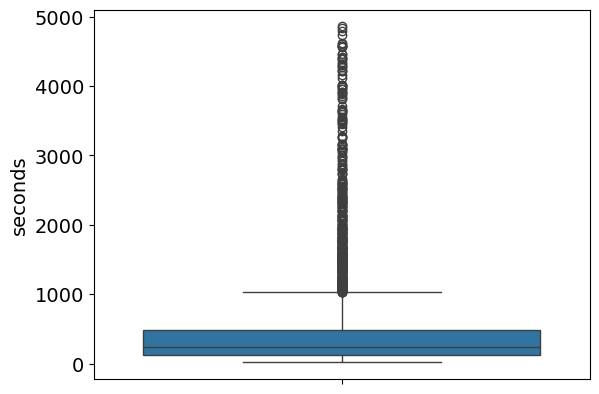

In [196]:
sns.boxplot(data=test2_dd_ss_f, y='seconds')

##### default

In [198]:
default_2 = default[['hit_at', 'anonymous_id']]

default_2

,hit_at,anonymous_id
467677,2020-11-26 00:00:10.318 UTC,8fe5810d-905c-462d-944b-66921878fa7d
432135,2020-11-26 00:00:17.474 UTC,3ce00502-94c0-41c8-8165-20ea6d2ecd73
250308,2020-11-26 00:00:19.951 UTC,e9030181-192e-4636-9691-2ba4d1eeabb2
489342,2020-11-26 00:00:24.159 UTC,20e24ee6-e40e-4f9a-9631-7db36332c734
144584,2020-11-26 00:00:25.857 UTC,e9480708-34a6-4356-8e65-b39664875cb9
...,...,...
30732,2020-12-10 23:59:18.618 UTC,5e518207-82fb-48b9-9764-c167e84dc57c
430450,2020-12-10 23:59:35.345 UTC,90b60ec1-4d0e-4fab-8cf0-6c5c128ea5ec
35510,2020-12-10 23:59:36.293 UTC,454c7515-0a58-4822-a431-d271e91da190
199014,2020-12-10 23:59:48.461 UTC,ad4b596b-88d3-41e9-969a-7d988039405b


In [199]:
default_2_lw = default_2.merge(landing_v, on='anonymous_id', how='left') \
    .rename(columns={'timestamp': 'landing_time'})

default_2_lw

,hit_at,anonymous_id,landing_time
0,2020-11-26 00:00:10.318 UTC,8fe5810d-905c-462d-944b-66921878fa7d,NaN
1,2020-11-26 00:00:17.474 UTC,3ce00502-94c0-41c8-8165-20ea6d2ecd73,NaN
2,2020-11-26 00:00:19.951 UTC,e9030181-192e-4636-9691-2ba4d1eeabb2,NaN
3,2020-11-26 00:00:24.159 UTC,20e24ee6-e40e-4f9a-9631-7db36332c734,2020-11-26 00:00:23.992 UTC
4,2020-11-26 00:00:25.857 UTC,e9480708-34a6-4356-8e65-b39664875cb9,2020-11-26 00:00:25.888 UTC
...,...,...,...
552143,2020-12-10 23:59:18.618 UTC,5e518207-82fb-48b9-9764-c167e84dc57c,2020-12-10 23:59:18.603 UTC
552144,2020-12-10 23:59:35.345 UTC,90b60ec1-4d0e-4fab-8cf0-6c5c128ea5ec,NaN
552145,2020-12-10 23:59:36.293 UTC,454c7515-0a58-4822-a431-d271e91da190,2020-12-10 23:59:36.278 UTC
552146,2020-12-10 23:59:48.461 UTC,ad4b596b-88d3-41e9-969a-7d988039405b,NaN


In [200]:
default2_lw_grouped = default_2_lw.groupby(['anonymous_id', 'landing_time'], as_index=False).agg({'hit_at' : 'count'}) \
    .sort_values(['anonymous_id', 'landing_time'], ascending=True)

default2_lw_grouped

,anonymous_id,landing_time,hit_at
0,00001104-4c72-4f48-bb8c-ace2ded63f8b,2020-12-05 10:01:51.305 UTC,1
1,00007575-88d6-4acc-9940-e9ccb8358dca,2020-12-08 11:07:39.962 UTC,1
2,00016e45-138b-401e-9eac-78b92d48c6c4,2020-12-03 13:12:37.952 UTC,1
3,0001814e-5cf7-4d23-bc95-4630d9152fc1,2020-12-02 16:03:37.548 UTC,1
4,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787 UTC,1
...,...,...,...
305129,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768 UTC,1
305130,fffee334-8e5d-4923-b97e-c3ebb060d70b,2020-12-04 19:15:55.857 UTC,1
305131,fffee334-8e5d-4923-b97e-c3ebb060d70b,2020-12-10 10:47:30.204 UTC,1
305132,ffff53e1-df50-43dd-a1d3-c2e34271920b,2020-12-07 06:11:38.61 UTC,1


In [201]:
default2_lw_grouped[default2_lw_grouped.anonymous_id.duplicated(keep=False)== True]

,anonymous_id,landing_time,hit_at
9,0002d40b-12e4-4729-8065-a2b9613c1c6d,2020-12-02 07:36:39.49 UTC,1
10,0002d40b-12e4-4729-8065-a2b9613c1c6d,2020-12-02 07:37:14.549 UTC,1
11,0002d40b-12e4-4729-8065-a2b9613c1c6d,2020-12-02 07:37:45.927 UTC,1
16,000544b6-143b-4c9c-a2eb-d4e99fb4b89f,2020-12-07 20:44:21.678 UTC,1
17,000544b6-143b-4c9c-a2eb-d4e99fb4b89f,2020-12-10 01:49:21.899 UTC,1
...,...,...,...
305124,fffe5596-010c-4987-99e3-c74f17d5bdc6,2020-12-01 15:32:02.754 UTC,1
305125,fffe5596-010c-4987-99e3-c74f17d5bdc6,2020-12-01 15:33:40.348 UTC,1
305126,fffe5596-010c-4987-99e3-c74f17d5bdc6,2020-12-01 15:37:37.887 UTC,1
305130,fffee334-8e5d-4923-b97e-c3ebb060d70b,2020-12-04 19:15:55.857 UTC,1


In [202]:
pd_added_grouped = product_added.reset_index() \
    .groupby(['anonymous_id', 'timestamp'], as_index=False).agg({'index' : 'count'}) \
    .sort_values(['anonymous_id', 'timestamp'], ascending=True)

pd_added_grouped

,anonymous_id,timestamp,index
0,00000782-154a-4159-ab12-6c34b658e375,2020-11-28 07:50:05.58 UTC,1
1,00000782-154a-4159-ab12-6c34b658e375,2020-11-28 07:50:15.865 UTC,1
2,00000782-154a-4159-ab12-6c34b658e375,2020-11-29 08:23:16.22 UTC,1
3,00000782-154a-4159-ab12-6c34b658e375,2020-11-29 08:26:09.465 UTC,1
4,00000782-154a-4159-ab12-6c34b658e375,2020-11-29 08:26:34.235 UTC,1
...,...,...,...
1150055,ffff5651-7253-4b44-9d35-95d0cdd89622,2020-12-02 07:39:33.915 UTC,1
1150056,ffff5651-7253-4b44-9d35-95d0cdd89622,2020-12-02 07:39:41.419 UTC,1
1150057,ffff5651-7253-4b44-9d35-95d0cdd89622,2020-12-02 07:43:55.574 UTC,1
1150058,ffff5651-7253-4b44-9d35-95d0cdd89622,2020-12-02 07:44:07.568 UTC,1


In [203]:
default2_added = default2_lw_grouped.merge(pd_added_grouped, on='anonymous_id', how='left') \
    .rename(columns={'timestamp': 'added_time'})

default2_added

,anonymous_id,landing_time,hit_at,added_time,index
0,00001104-4c72-4f48-bb8c-ace2ded63f8b,2020-12-05 10:01:51.305 UTC,1,NaN,NaN
1,00007575-88d6-4acc-9940-e9ccb8358dca,2020-12-08 11:07:39.962 UTC,1,NaN,NaN
2,00016e45-138b-401e-9eac-78b92d48c6c4,2020-12-03 13:12:37.952 UTC,1,NaN,NaN
3,0001814e-5cf7-4d23-bc95-4630d9152fc1,2020-12-02 16:03:37.548 UTC,1,NaN,NaN
4,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787 UTC,1,2020-12-01 08:26:17.26 UTC,1.0
...,...,...,...,...,...
2138927,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768 UTC,1,2020-12-13 14:57:32.371 UTC,1.0
2138928,fffee334-8e5d-4923-b97e-c3ebb060d70b,2020-12-04 19:15:55.857 UTC,1,NaN,NaN
2138929,fffee334-8e5d-4923-b97e-c3ebb060d70b,2020-12-10 10:47:30.204 UTC,1,NaN,NaN
2138930,ffff53e1-df50-43dd-a1d3-c2e34271920b,2020-12-07 06:11:38.61 UTC,1,NaN,NaN


In [204]:
default2_added_filt = default2_added[default2_added['added_time'].isna() == False].drop(columns=['hit_at', 'index'])

default2_added_filt

,anonymous_id,landing_time,added_time
4,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787 UTC,2020-12-01 08:26:17.26 UTC
5,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787 UTC,2020-12-01 08:26:30.751 UTC
6,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787 UTC,2020-12-01 08:26:42.996 UTC
7,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787 UTC,2020-12-01 08:27:14.09 UTC
8,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787 UTC,2020-12-01 08:27:16.127 UTC
...,...,...,...
2138923,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768 UTC,2020-12-13 14:51:49.327 UTC
2138924,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768 UTC,2020-12-13 14:54:43.14 UTC
2138925,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768 UTC,2020-12-13 14:55:38.131 UTC
2138926,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768 UTC,2020-12-13 14:57:30.738 UTC


In [205]:
default2_added_grouped = default2_added_filt.reset_index() \
    .groupby(['anonymous_id', 'landing_time', 'added_time'], as_index=False).agg({'index' : 'count'}) \
    .sort_values(['anonymous_id', 'landing_time', 'added_time'], ascending=True)

default2_added_grouped

,anonymous_id,landing_time,added_time,index
0,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787 UTC,2020-12-01 08:26:17.26 UTC,1
1,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787 UTC,2020-12-01 08:26:30.751 UTC,1
2,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787 UTC,2020-12-01 08:26:42.996 UTC,1
3,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787 UTC,2020-12-01 08:27:14.09 UTC,1
4,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787 UTC,2020-12-01 08:27:16.127 UTC,1
...,...,...,...,...
1884634,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768 UTC,2020-12-13 14:51:49.327 UTC,1
1884635,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768 UTC,2020-12-13 14:54:43.14 UTC,1
1884636,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768 UTC,2020-12-13 14:55:38.131 UTC,1
1884637,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768 UTC,2020-12-13 14:57:30.738 UTC,1


In [206]:
default2_added_dd = default2_added_grouped.drop_duplicates(subset=['landing_time']).drop(columns='index')

default2_added_dd

,anonymous_id,landing_time,added_time
0,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787 UTC,2020-12-01 08:26:17.26 UTC
20,0003ca8f-bb3f-4954-84c7-1fbf2353a454,2020-11-27 14:21:08.794 UTC,2020-11-27 15:36:24.14 UTC
29,000cca0e-514d-42fd-ba72-ec3b3917732f,2020-11-27 07:51:07.12 UTC,2020-11-27 07:59:17.56 UTC
30,001197b2-8203-476a-8494-bbb11ee2a184,2020-11-29 08:06:16.163 UTC,2020-11-29 08:30:44.518 UTC
76,00179381-fef4-4126-b3d4-51d3c668ff5d,2020-12-04 23:13:50.538 UTC,2020-12-04 23:16:08.027 UTC
...,...,...,...
1884465,ffede928-c305-44d9-9c4b-6f04f0f2438f,2020-11-27 07:17:36.349 UTC,2020-11-27 07:24:16.798 UTC
1884467,fff6349b-c93d-4933-9925-6ff7d27c873e,2020-11-29 14:09:55.347 UTC,2020-11-26 03:02:44.54 UTC
1884477,fff6349b-c93d-4933-9925-6ff7d27c873e,2020-12-10 08:15:20.968 UTC,2020-11-26 03:02:44.54 UTC
1884487,fffbbed0-9af0-436d-b6de-4d530c9f7112,2020-12-06 12:54:19.526 UTC,2020-12-06 14:09:21.552 UTC


In [207]:



default2_added_dd['added_time'] = pd.to_datetime(default2_added_dd['added_time'], utc=True, errors='coerce')
default2_added_dd['landing_time'] = pd.to_datetime(default2_added_dd['landing_time'], utc=True, errors='coerce')


default2_added_dd['time_delta'] = default2_added_dd['added_time'] - default2_added_dd['landing_time']


default2_added_dd['time_delta_minutes'] = default2_added_dd['time_delta'].dt.total_seconds() / 60


In [208]:
default2_added_dd['seconds'] = default2_added_dd.time_delta.dt.total_seconds()

default2_added_dd

,anonymous_id,landing_time,added_time,time_delta,time_delta_minutes,seconds
0,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787000+00:00,2020-12-01 08:26:17.260000+00:00,0 days 00:01:25.473000,1.424550,85.473
20,0003ca8f-bb3f-4954-84c7-1fbf2353a454,2020-11-27 14:21:08.794000+00:00,2020-11-27 15:36:24.140000+00:00,0 days 01:15:15.346000,75.255767,4515.346
29,000cca0e-514d-42fd-ba72-ec3b3917732f,2020-11-27 07:51:07.120000+00:00,2020-11-27 07:59:17.560000+00:00,0 days 00:08:10.440000,8.174000,490.440
30,001197b2-8203-476a-8494-bbb11ee2a184,2020-11-29 08:06:16.163000+00:00,2020-11-29 08:30:44.518000+00:00,0 days 00:24:28.355000,24.472583,1468.355
76,00179381-fef4-4126-b3d4-51d3c668ff5d,2020-12-04 23:13:50.538000+00:00,2020-12-04 23:16:08.027000+00:00,0 days 00:02:17.489000,2.291483,137.489
...,...,...,...,...,...,...
1884465,ffede928-c305-44d9-9c4b-6f04f0f2438f,2020-11-27 07:17:36.349000+00:00,2020-11-27 07:24:16.798000+00:00,0 days 00:06:40.449000,6.674150,400.449
1884467,fff6349b-c93d-4933-9925-6ff7d27c873e,2020-11-29 14:09:55.347000+00:00,2020-11-26 03:02:44.540000+00:00,-4 days +12:52:49.193000,-4987.180117,-299230.807
1884477,fff6349b-c93d-4933-9925-6ff7d27c873e,2020-12-10 08:15:20.968000+00:00,2020-11-26 03:02:44.540000+00:00,-15 days +18:47:23.572000,-20472.607133,-1228356.428
1884487,fffbbed0-9af0-436d-b6de-4d530c9f7112,2020-12-06 12:54:19.526000+00:00,2020-12-06 14:09:21.552000+00:00,0 days 01:15:02.026000,75.033767,4502.026


In [209]:
default2_dd_ss = default2_added_dd[default2_added_dd['seconds'] > 0].sort_values('seconds')

default2_dd_ss

,anonymous_id,landing_time,added_time,time_delta,time_delta_minutes,seconds
833744,6f751329-6ef7-4c68-b252-0c2c66d21cad,2020-12-01 18:54:07.506000+00:00,2020-12-01 18:54:17.710000+00:00,0 days 00:00:10.204000,0.170067,10.204
317451,21c925b0-5751-4e5a-b572-75101faf612b,2020-12-04 19:35:06.070000+00:00,2020-12-04 19:35:16.288000+00:00,0 days 00:00:10.218000,0.170300,10.218
929655,7b69588f-4f61-4abc-a026-4a3fb4ff84e3,2020-11-30 07:29:05.323000+00:00,2020-11-30 07:29:15.696000+00:00,0 days 00:00:10.373000,0.172883,10.373
317294,21c925b0-5751-4e5a-b572-75101faf612b,2020-12-04 19:35:05.309000+00:00,2020-12-04 19:35:16.288000+00:00,0 days 00:00:10.979000,0.182983,10.979
317137,21c925b0-5751-4e5a-b572-75101faf612b,2020-12-04 19:35:04.238000+00:00,2020-12-04 19:35:16.288000+00:00,0 days 00:00:12.050000,0.200833,12.050
...,...,...,...,...,...,...
522384,41f56239-b76c-4a96-a0bd-db2a55130a0a,2020-11-27 02:44:25.985000+00:00,2020-12-17 16:15:01.703000+00:00,20 days 13:30:35.718000,29610.595300,1776635.718
1264532,a7741d69-fd9d-41c0-9f8f-2568eebd777c,2020-11-26 05:59:27.243000+00:00,2020-12-17 06:15:46.884000+00:00,21 days 00:16:19.641000,30256.327350,1815379.641
1264505,a7741d69-fd9d-41c0-9f8f-2568eebd777c,2020-11-26 05:58:22.055000+00:00,2020-12-17 06:15:46.884000+00:00,21 days 00:17:24.829000,30257.413817,1815444.829
1264478,a7741d69-fd9d-41c0-9f8f-2568eebd777c,2020-11-26 05:57:55.037000+00:00,2020-12-17 06:15:46.884000+00:00,21 days 00:17:51.847000,30257.864117,1815471.847


In [210]:
default2_dd_ss.seconds.describe()

count    3.475400e+04
mean     7.648058e+04
std      2.288420e+05
min      1.020400e+01
25%      1.927950e+02
50%      4.252135e+02
75%      2.381614e+03
max      1.848756e+06
Name: seconds, dtype: float64

In [211]:

q1, q3, iqr = iq_range(default2_dd_ss, 'seconds')

In [212]:

default2_dd_ss_f = default2_dd_ss.query('(@q1 - 1.5*@iqr) <= seconds <= (@q3 + 1.5*@iqr)')
default2_dd_ss_f

,anonymous_id,landing_time,added_time,time_delta,time_delta_minutes,seconds
833744,6f751329-6ef7-4c68-b252-0c2c66d21cad,2020-12-01 18:54:07.506000+00:00,2020-12-01 18:54:17.710000+00:00,0 days 00:00:10.204000,0.170067,10.204
317451,21c925b0-5751-4e5a-b572-75101faf612b,2020-12-04 19:35:06.070000+00:00,2020-12-04 19:35:16.288000+00:00,0 days 00:00:10.218000,0.170300,10.218
929655,7b69588f-4f61-4abc-a026-4a3fb4ff84e3,2020-11-30 07:29:05.323000+00:00,2020-11-30 07:29:15.696000+00:00,0 days 00:00:10.373000,0.172883,10.373
317294,21c925b0-5751-4e5a-b572-75101faf612b,2020-12-04 19:35:05.309000+00:00,2020-12-04 19:35:16.288000+00:00,0 days 00:00:10.979000,0.182983,10.979
317137,21c925b0-5751-4e5a-b572-75101faf612b,2020-12-04 19:35:04.238000+00:00,2020-12-04 19:35:16.288000+00:00,0 days 00:00:12.050000,0.200833,12.050
...,...,...,...,...,...,...
1170794,9b10df88-4c2e-4751-ba55-917d291f9b52,2020-12-06 07:48:44.482000+00:00,2020-12-06 09:22:51.419000+00:00,0 days 01:34:06.937000,94.115617,5646.937
1112769,9579b2e7-5b04-4614-99ae-aa23644cf7bc,2020-12-07 06:07:07.341000+00:00,2020-12-07 07:41:20.075000+00:00,0 days 01:34:12.734000,94.212233,5652.734
1603916,d8cc10a1-9ce0-4fd2-a869-acef87d99d46,2020-12-01 11:59:11.047000+00:00,2020-12-01 13:33:25.440000+00:00,0 days 01:34:14.393000,94.239883,5654.393
189022,0f91659c-17e4-4892-ad7e-c4f050ccef84,2020-11-27 13:31:33.467000+00:00,2020-11-27 15:05:52.404000+00:00,0 days 01:34:18.937000,94.315617,5658.937


In [213]:
default2_dd_ss_f.seconds.describe()

count    27394.000000
mean       596.195279
std        844.297992
min         10.204000
25%        161.200750
50%        300.276500
75%        614.195000
max       5664.323000
Name: seconds, dtype: float64

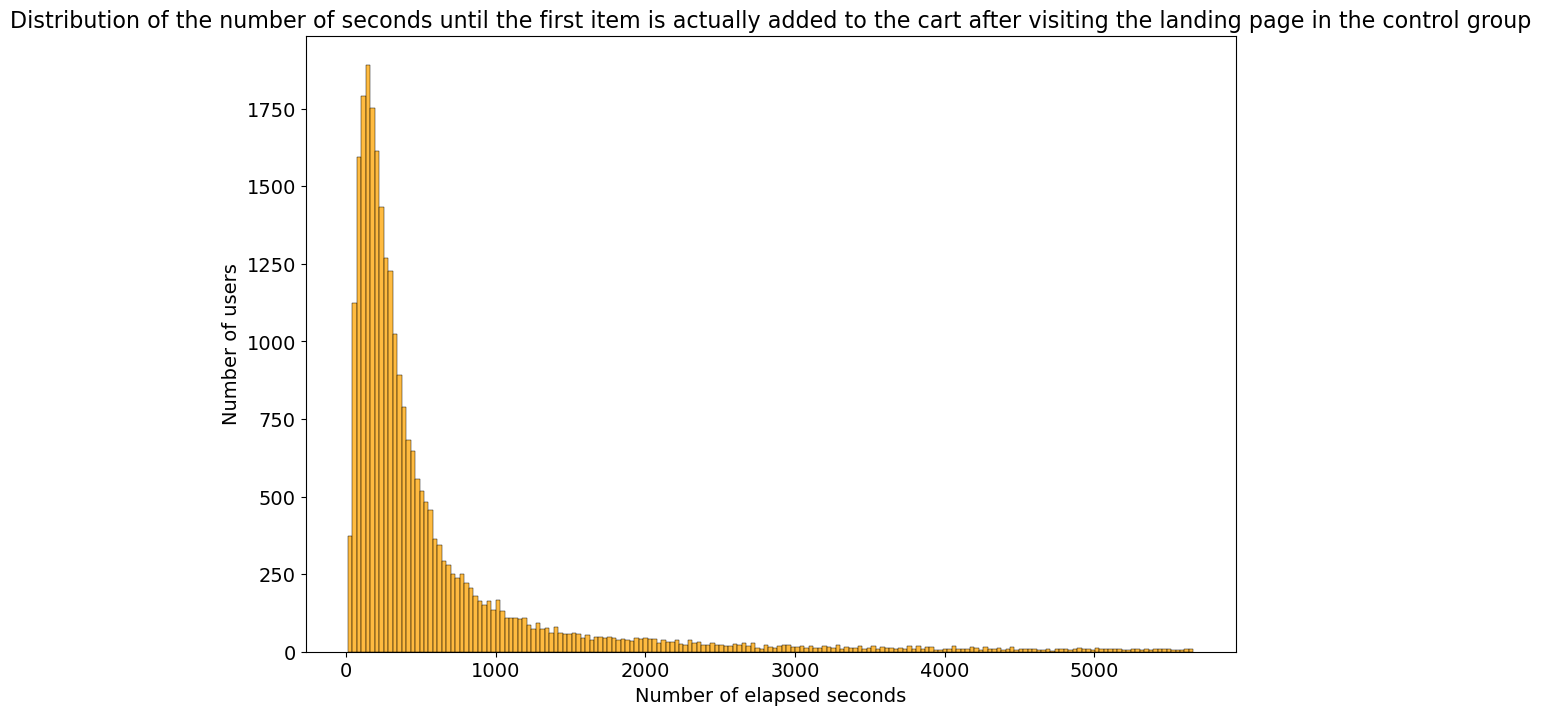

In [215]:

plt.figure(figsize=(12, 8))
ax = sns.histplot(data=default2_dd_ss_f, x='seconds', color='orange')

ax.set_xlabel('Number of elapsed seconds',fontsize=14)
ax.set_ylabel('Number of users',fontsize=14)
ax.set_title('Distribution of the number of seconds until the first item is actually added to the cart after visiting the landing page in the control group', fontsize=16);

plt.savefig('default_seconds.png')

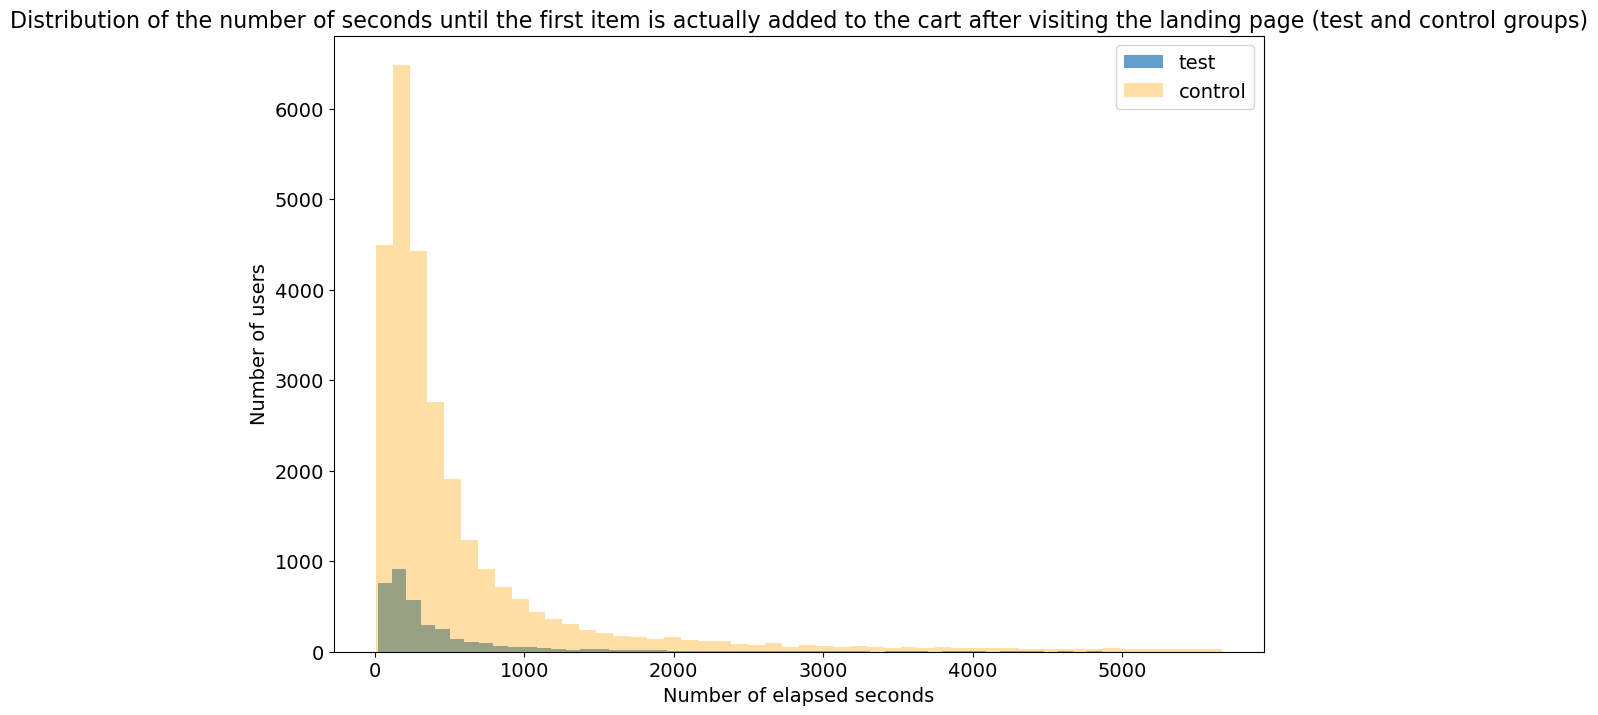

In [216]:

plt.figure(figsize=(12, 8))
test2_dd_ss_f.seconds.plot(kind='hist', alpha=0.7, legend=True, label='test', bins=50)
default2_dd_ss_f.seconds.plot(kind='hist', alpha=0.35, legend=True, label='control', bins=50, color='orange');

plt.xlabel('Number of elapsed seconds',fontsize=14)
plt.ylabel('Number of users',fontsize=14)
plt.title('Distribution of the number of seconds until the first item is actually added to the cart after visiting the landing page (test and control groups)', fontsize=16);

plt.savefig('both_seconds.png')

In [217]:

result = st.shapiro(default2_dd_ss_f.seconds.sample(1000, random_state=17))  # sample 1000 для стабильности теста

print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('The distribution is normal..')
else:
    print('The distribution is not normal.')

test statistic = 0.6089, pvalue = 1.1524e-42
The distribution is not normal.


#### AB-test Number of seconds to add an item to the cart

In [219]:
default2_dd_ss_f.seconds.mean()

596.1952792582317

In [220]:
test2_dd_ss_f.seconds.mean()

476.963049918611

In [221]:

alpha = 0.05

result = st.mannwhitneyu(default2_dd_ss_f.seconds,
                      test2_dd_ss_f.seconds,
                      alternative='two-sided')

print('U statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result.pvalue < 0.05:
    print('We reject the null hypothesis of equal means of the two samples.')
    if test2_dd_ss_f.seconds.mean() > default2_dd_ss_f.seconds.mean():
        print('Failed to reduce the number of seconds spent adding the first item to the cart after visiting the landing page.')
    else:
        print('The number of seconds spent adding the first item to the cart after visiting the landing page was successfully reduced. Now users spend less time from visiting the landing page to adding the first item to the cart..')
else:
    print('We do not have enough evidence to reject the null hypothesis and accept the alternative.')

U statistic = 56872551.0000, pvalue = 8.8918e-36
We reject the null hypothesis of equal means of the two samples.
The number of seconds spent adding the first item to the cart after visiting the landing page was successfully reduced. Now users spend less time from visiting the landing page to adding the first item to the cart..
